# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Loading

In [ ]:
# Load data
data = pd.read_csv('MSFT_2006-01-01_to_2018-01-01.csv')

# Data summary and visualization
print("Dataset Head:\n", data.head())
print("Dataset Shape:\n",data.shape)

Dataset Head:
          Date   Open   High    Low  Close     Volume  Name
0  2006-01-03  26.25  27.00  26.10  26.84   79974418  MSFT
1  2006-01-04  26.77  27.08  26.77  26.97   57975661  MSFT
2  2006-01-05  26.96  27.13  26.91  26.99   48247610  MSFT
3  2006-01-06  26.89  27.00  26.49  26.91  100969092  MSFT
4  2006-01-09  26.93  27.07  26.76  26.86   55627836  MSFT
Dataset Shape:
 (3019, 7)


# Data Exploration

In [ ]:
# Remove last column (constant value)
data = data.iloc[:, :-1]

# Check for missing values
missing = data.isnull().any(axis=1)
print("Rows with missing values:\n", data[missing])


Rows with missing values:
 Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume]
Index: []


In [ ]:
# Display date range
print("Date Range:", data['Date'].min(), "to", data['Date'].max())

Date Range: 2006-01-03 to 2017-12-29


In [ ]:
# Date processing for trading days per year
data['Date'] = pd.to_datetime(data['Date'], format='mixed')

years = data['Date'].dt.year
unique_years = years.unique()
date_counts = [sum(years == year) for year in unique_years]

# Display yearly count table
yearly_counts = pd.DataFrame({'Year': unique_years, 'Count': date_counts})
print(yearly_counts)

    Year  Count
0   2006    251
1   2007    251
2   2008    253
3   2009    252
4   2010    251
5   2011    252
6   2012    250
7   2013    252
8   2014    252
9   2015    252
10  2016    252
11  2017    251


# Missing weekdays

In [ ]:
# Define the complete date range
full_date_range = pd.date_range(start='2006-01-03', end='2017-12-29', freq='D')  # All days in the range

# Identify missing dates
missing_dates = full_date_range.difference(data['Date'])

# Exclude Saturdays (5) and Sundays (6)
missing_dates_weekdays = [date for date in missing_dates if date.weekday() < 5]

# Convert to DataFrame for storage or further analysis
missing_dates_df = pd.DataFrame({'MissingDate': missing_dates_weekdays})

# Print results
print("All missing dates (excluding Saturdays and Sundays):")
print(missing_dates_df)

All missing dates (excluding Saturdays and Sundays):
    MissingDate
0    2006-01-16
1    2006-02-20
2    2006-04-14
3    2006-05-29
4    2006-07-04
..          ...
105  2017-05-29
106  2017-07-04
107  2017-09-04
108  2017-11-23
109  2017-12-25

[110 rows x 1 columns]


Missing Weekdays Imputation

In [ ]:
# Create a copy of the data for imputation
original_data = data.copy()

# Loop through each missing date
for date in missing_dates_df['MissingDate']:
    # Find the previous and following dates
    previous_date = data[data['Date'] < date]['Date'].max()
    following_date = data[data['Date'] > date]['Date'].min()

    # Calculate the mean for all columns except 'Date'
    new_row = {'Date': date}
    for col in data.columns:
        if col != 'Date':
            previous_value = data.loc[data['Date'] == previous_date, col].values[0]
            following_value = data.loc[data['Date'] == following_date, col].values[0]
            new_row[col] = (previous_value + following_value) / 2

    # Append the new row
    data = pd.concat([data, pd.DataFrame([new_row])], ignore_index=True)

# Sort by date to ensure chronological order
data = data.sort_values(by='Date').reset_index(drop=True)

# Print the imputed dataset
print(data)

           Date    Open   High     Low   Close       Volume
0    2006-01-03  26.250  27.00  26.100  26.840   79974418.0
1    2006-01-04  26.770  27.08  26.770  26.970   57975661.0
2    2006-01-05  26.960  27.13  26.910  26.990   48247610.0
3    2006-01-06  26.890  27.00  26.490  26.910  100969092.0
4    2006-01-09  26.930  27.07  26.760  26.860   55627836.0
...         ...     ...    ...     ...     ...          ...
3124 2017-12-25  85.355  85.58  84.975  85.455   12018539.0
3125 2017-12-26  85.310  85.53  85.030  85.400    9891237.0
3126 2017-12-27  85.650  85.98  85.220  85.710   14678025.0
3127 2017-12-28  85.900  85.93  85.550  85.720   10594344.0
3128 2017-12-29  85.630  86.05  85.500  85.540   18717406.0

[3129 rows x 6 columns]


In [ ]:
pip install pandas_market_calendars

In [ ]:

import pandas_market_calendars as mcal
nyse = mcal.get_calendar('NYSE')

# Define the date range based on your specified range
start_date = '2006-01-03'
end_date = '2017-12-29'

# Get the trading schedule for the given date range
schedule = nyse.schedule(start_date=start_date, end_date=end_date)
trading_days = schedule.index

# Check if trading days match data['Date']
missing_in_data = set(trading_days) - set(data['Date'])

# Print results
if not missing_in_data:
    print("All trading days are with data['Date'].")
else:
    print(f"Trading days missing in data['Date']: {sorted(missing_in_data)}")

All trading days are with data['Date'].


# Understand and Visualize the data

In [ ]:
# Summary statistics
print(data.describe())

                                Date         Open         High         Low  \
count                           3129  3129.000000  3129.000000  3129.00000   
mean   2012-01-01 04:47:37.909875200    36.488142    36.817755    36.16631   
min              2006-01-03 00:00:00    15.200000    15.620000    14.87000   
25%              2009-01-01 00:00:00    26.800000    27.060000    26.56000   
50%              2012-01-02 00:00:00    29.990000    30.230000    29.78000   
75%              2014-12-31 00:00:00    44.480000    44.900000    44.06000   
max              2017-12-29 00:00:00    87.120000    87.500000    86.23000   
std                              NaN    14.673151    14.731234    14.60890   

             Close        Volume  
count  3129.000000  3.129000e+03  
mean     36.505228  5.125337e+07  
min      15.150000  7.425603e+06  
25%      26.840000  3.117109e+07  
50%      30.000000  4.599472e+07  
75%      44.395000  6.295082e+07  
max      86.850000  5.910786e+08  
std      14.68293

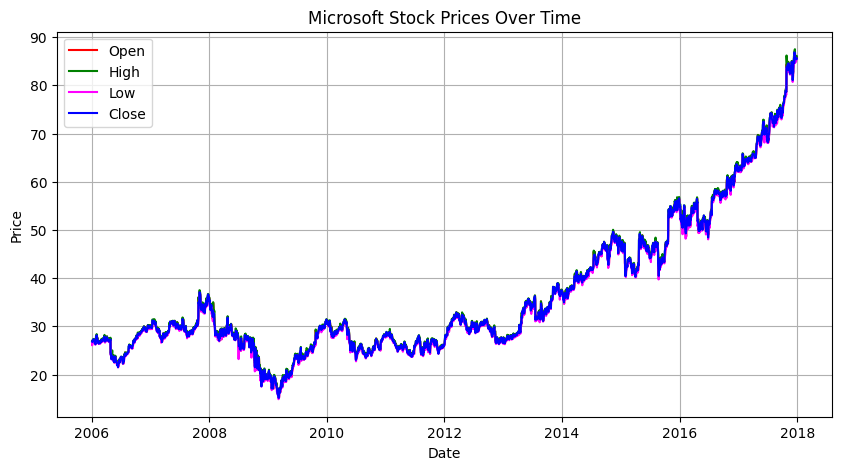

In [ ]:
# Data Visualization - Time Series Analysis
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Open'], label='Open', color='red')
plt.plot(data['Date'], data['High'], label='High', color='green')
plt.plot(data['Date'], data['Low'], label='Low', color='magenta')
plt.plot(data['Date'], data['Close'], label='Close', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Microsoft Stock Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()

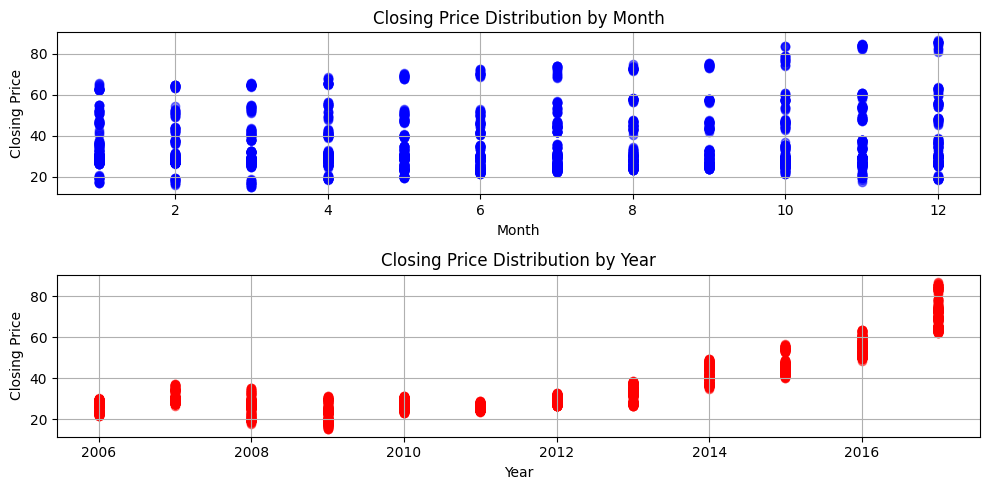

In [ ]:
# Closing Price Distribution over Months and Years
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.scatter(data['Date'].dt.month, data['Close'], color='b', alpha=0.5)
plt.title('Closing Price Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Closing Price')
plt.grid(True)


plt.subplot(2, 1, 2)
plt.scatter(data['Date'].dt.year, data['Close'], color='r', alpha=0.5)
plt.title('Closing Price Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Correlation between Volume and Close Price
correlation_coefficient = data['Close'].corr(data['Volume'])
print(f'The correlation between Volume and Close Price is: {correlation_coefficient:.4f}')


The correlation between Volume and Close Price is: -0.4854


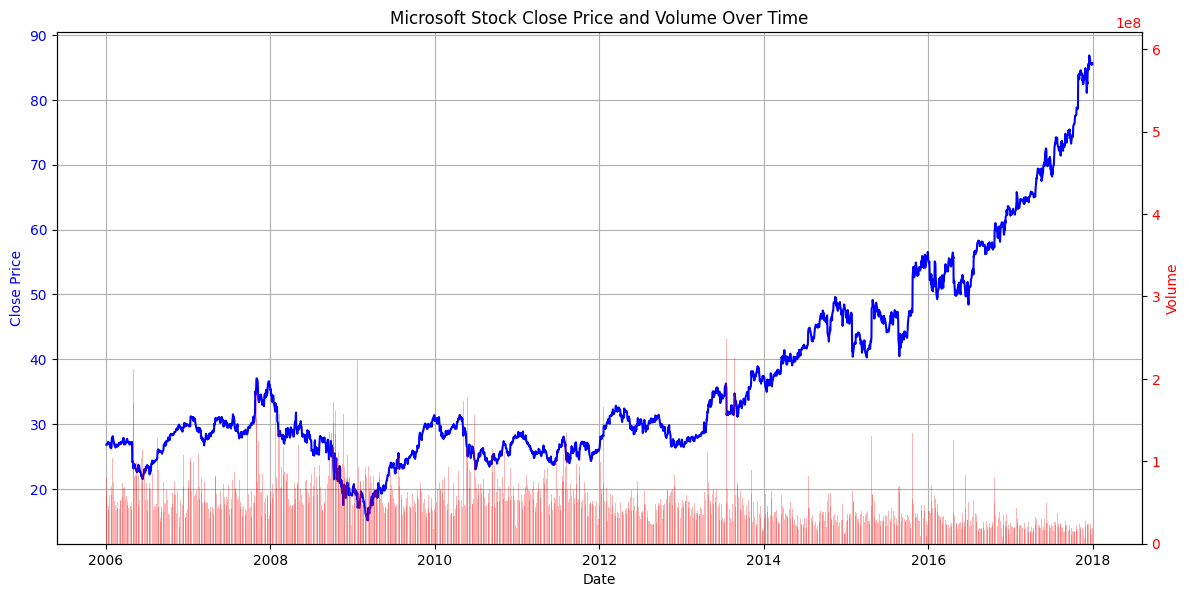

In [ ]:
# Dual-axis plot for Close Price vs. Volume
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(data['Date'], data['Close'], 'b-', linewidth=1.5, label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.bar(data['Date'], data['Volume'], alpha=0.3, color='r', width=1.5)
ax2.set_ylabel('Volume', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Microsoft Stock Close Price and Volume Over Time')
plt.show()

# Data Decomposition







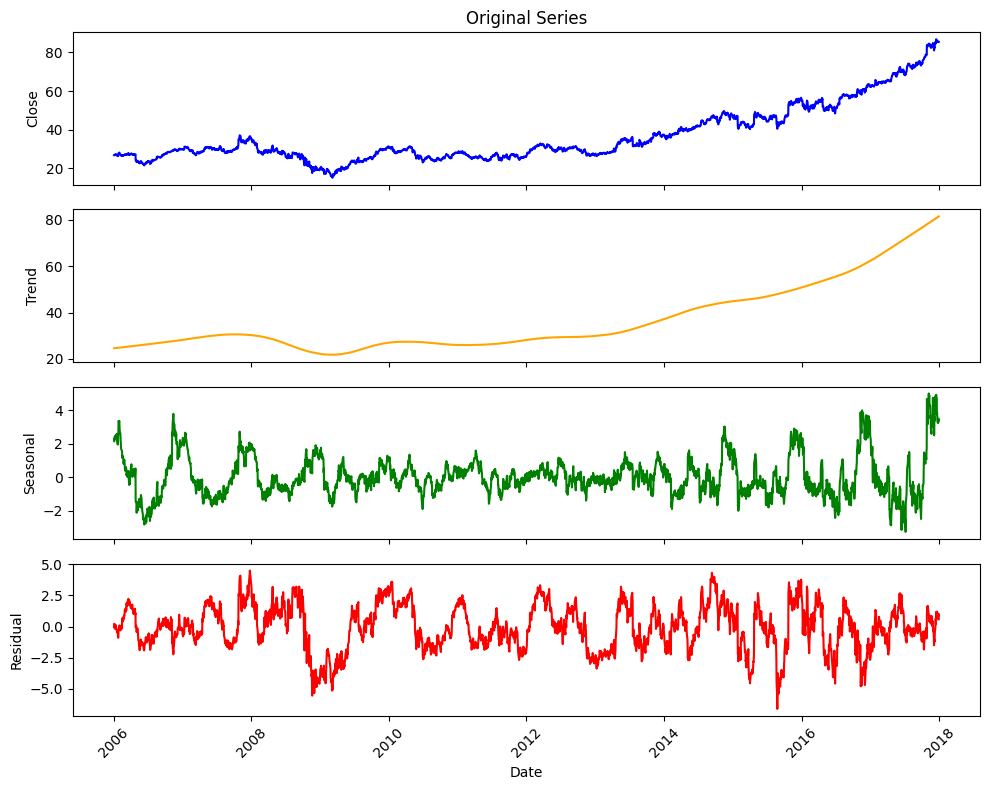

In [ ]:
from statsmodels.tsa.seasonal import STL

# Perform seasonal decomposition using STL (Seasonal-Trend decomposition using LOESS)
stl = STL(data['Close'], period=252)
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid

fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original series
ax[0].plot(data['Date'], data['Close'], color='blue')
ax[0].set_ylabel('Close')
ax[0].set_title('Original Series')

# Trend component
ax[1].plot(data['Date'], trend, color='orange')
ax[1].set_ylabel('Trend')

# Seasonal component
ax[2].plot(data['Date'], seasonal, color='green')
ax[2].set_ylabel('Seasonal')

# Residuals
ax[3].plot(data['Date'], residual, color='red')
ax[3].set_ylabel('Residual')

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Yearly, Monthly and Weekly Seasonality

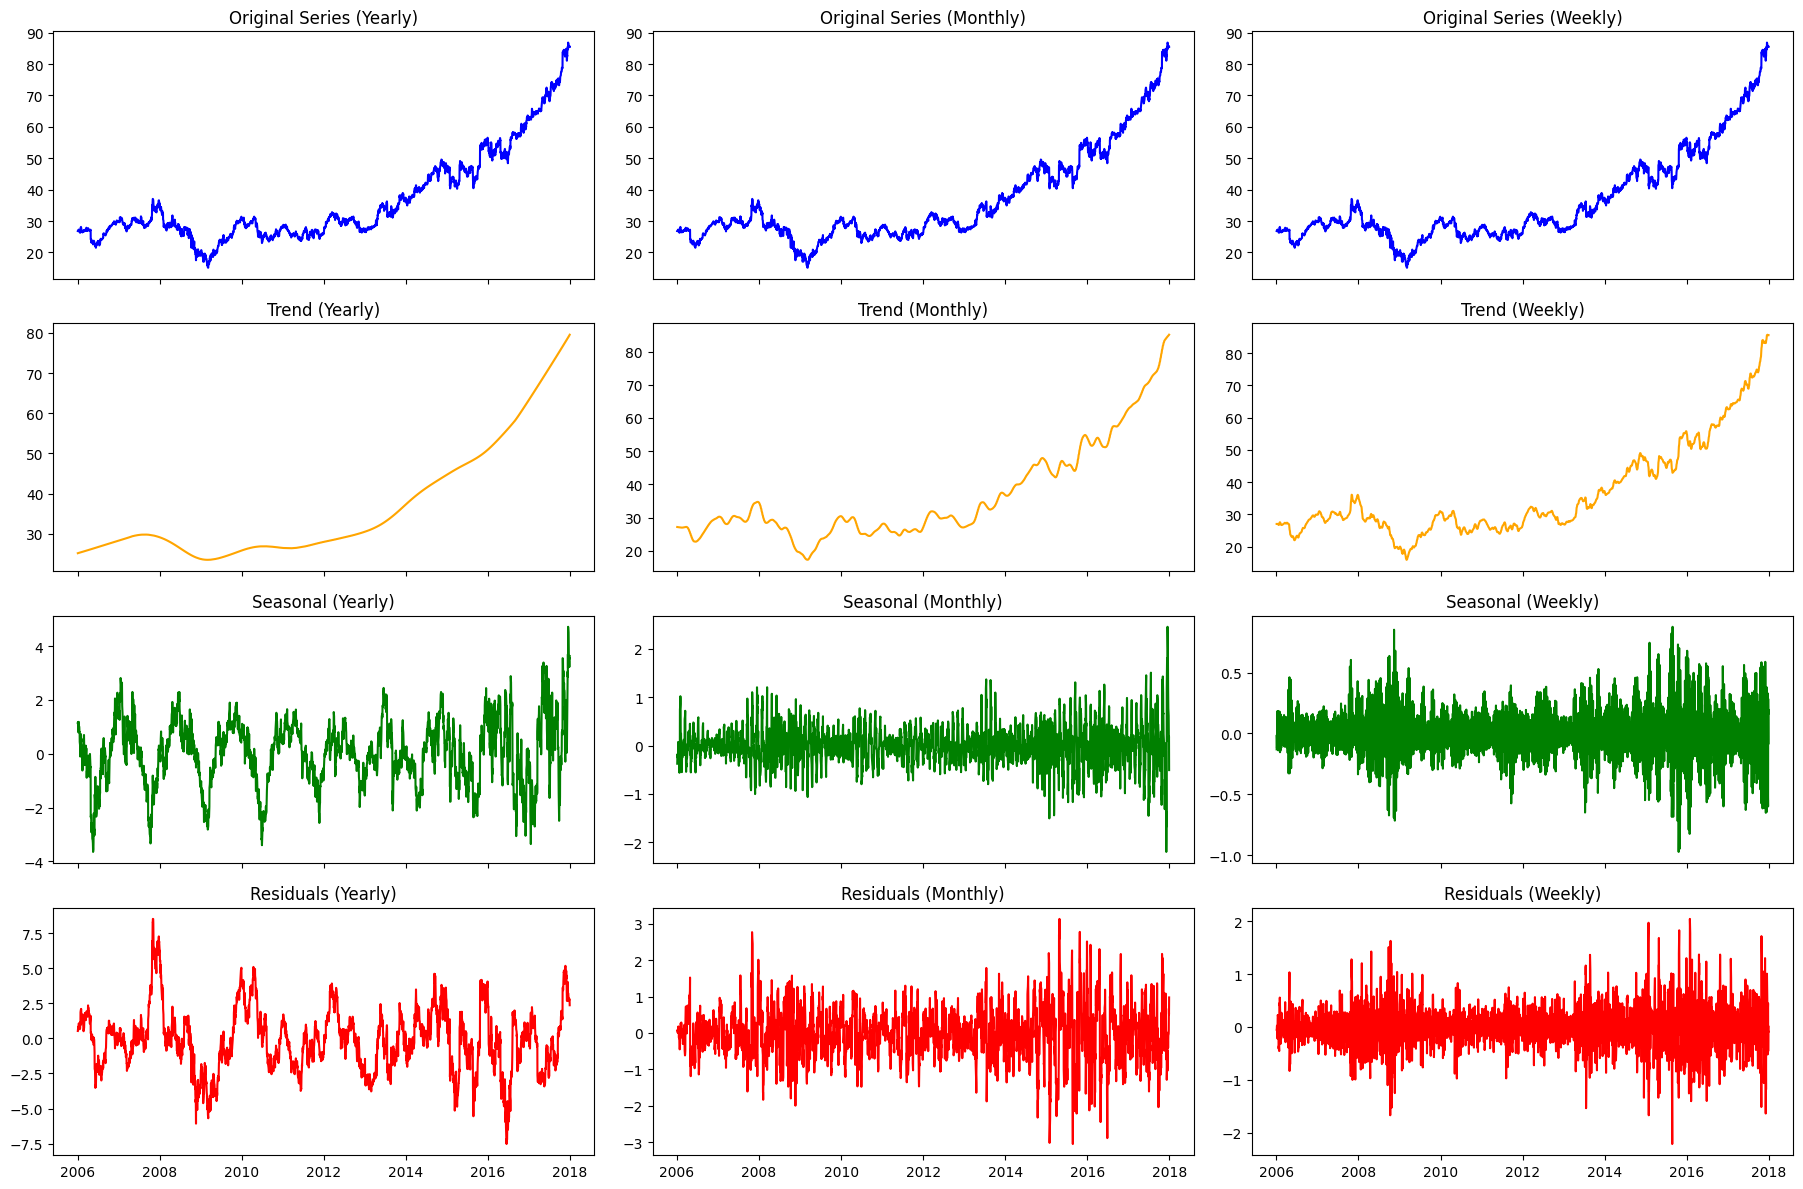

In [ ]:
# Yearly Seasonality (252 trading days for stock market data)
stl_yearly = STL(data['Close'], period=365)
result_yearly = stl_yearly.fit()

# Monthly Seasonality (approx. 30 days)
stl_monthly = STL(data['Close'], period=30)
result_monthly = stl_monthly.fit()

# Weekly Seasonality (7 days)
stl_weekly = STL(data['Close'], period=7)
result_weekly = stl_weekly.fit()

# Plotting the decompositions for yearly, monthly, and weekly seasonal components
fig, axes = plt.subplots(4, 3, figsize=(18, 12), sharex=True)

# Yearly decomposition
axes[0, 0].plot(data['Date'], data['Close'], color='blue')
axes[0, 0].set_title('Original Series (Yearly)')

axes[1, 0].plot(data['Date'], result_yearly.trend, color='orange')
axes[1, 0].set_title('Trend (Yearly)')

axes[2, 0].plot(data['Date'], result_yearly.seasonal, color='green')
axes[2, 0].set_title('Seasonal (Yearly)')

axes[3, 0].plot(data['Date'], result_yearly.resid, color='red')
axes[3, 0].set_title('Residuals (Yearly)')

# Monthly decomposition
axes[0, 1].plot(data['Date'], data['Close'], color='blue')
axes[0, 1].set_title('Original Series (Monthly)')

axes[1, 1].plot(data['Date'], result_monthly.trend, color='orange')
axes[1, 1].set_title('Trend (Monthly)')

axes[2, 1].plot(data['Date'], result_monthly.seasonal, color='green')
axes[2, 1].set_title('Seasonal (Monthly)')

axes[3, 1].plot(data['Date'], result_monthly.resid, color='red')
axes[3, 1].set_title('Residuals (Monthly)')

# Weekly decomposition
axes[0, 2].plot(data['Date'], data['Close'], color='blue')
axes[0, 2].set_title('Original Series (Weekly)')

axes[1, 2].plot(data['Date'], result_weekly.trend, color='orange')
axes[1, 2].set_title('Trend (Weekly)')

axes[2, 2].plot(data['Date'], result_weekly.seasonal, color='green')
axes[2, 2].set_title('Seasonal (Weekly)')

axes[3, 2].plot(data['Date'], result_weekly.resid, color='red')
axes[3, 2].set_title('Residuals (Weekly)')

plt.tight_layout()
plt.show()

# Autocorrelation of Closing Price (target variable)

<Figure size 1000x500 with 0 Axes>

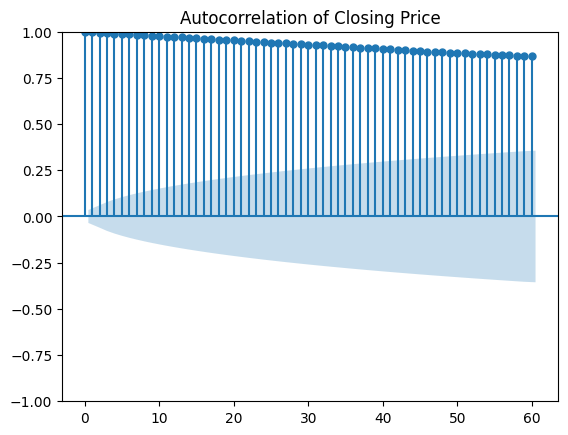

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrelation of Close Price
plt.figure(figsize=(10, 5))
plot_acf(data['Close'], lags=60)
plt.title('Autocorrelation of Closing Price')
plt.show()

# Outliers Detection

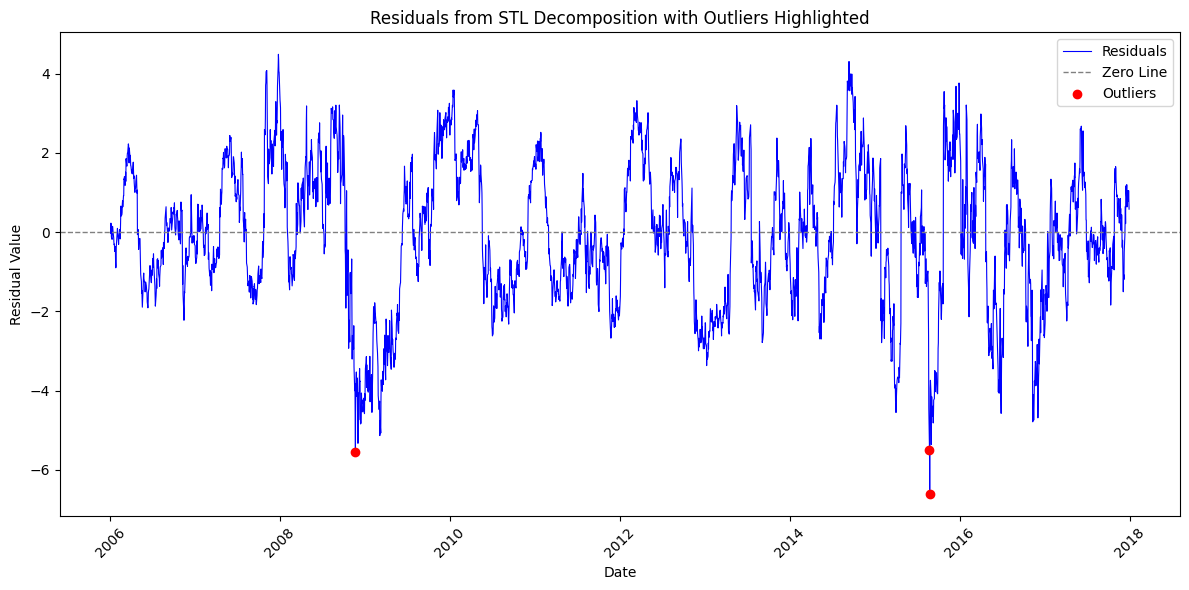

Outliers:
            Date  Close
752  2008-11-20  17.53
2514 2015-08-24  41.68
2515 2015-08-25  40.47


In [ ]:
# Define a threshold for outliers (3 standard deviations from the mean)
threshold = np.std(residual) * 3
outliers = residual[np.abs(residual) > threshold]

# Extract dates and residual values for outliers
outlier_dates = data['Date'][np.abs(residual) > threshold]
outlier_residual_values = residual[np.abs(residual) > threshold]

# Plotting residuals with outliers highlighted
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], residual, label='Residuals', color='blue', linewidth=0.8)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, label='Zero Line')
plt.title('Residuals from STL Decomposition with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('Residual Value')

# Highlight outliers
plt.scatter(outlier_dates, outlier_residual_values, color='red', label='Outliers', zorder=5)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

outlier_closing_values = data.loc[data['Date'].isin(outlier_dates), 'Close']

# Print outlier information
outlier_info = pd.DataFrame({'Date': outlier_dates, 'Close': outlier_closing_values})
print("Outliers:\n", outlier_info)

# Baseline model: Autoregressive

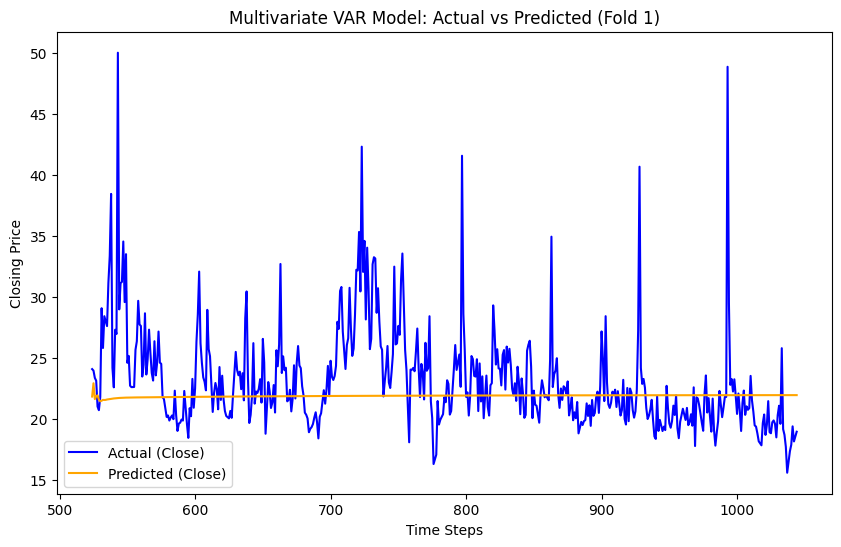

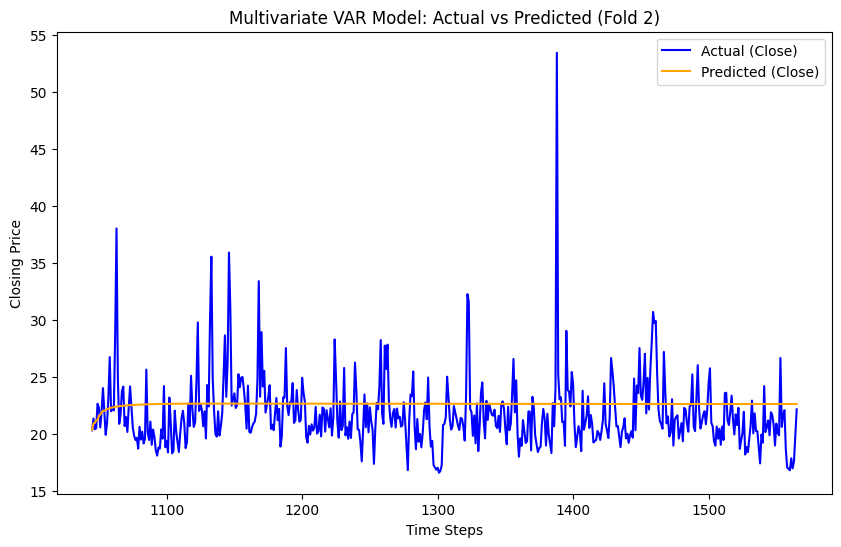

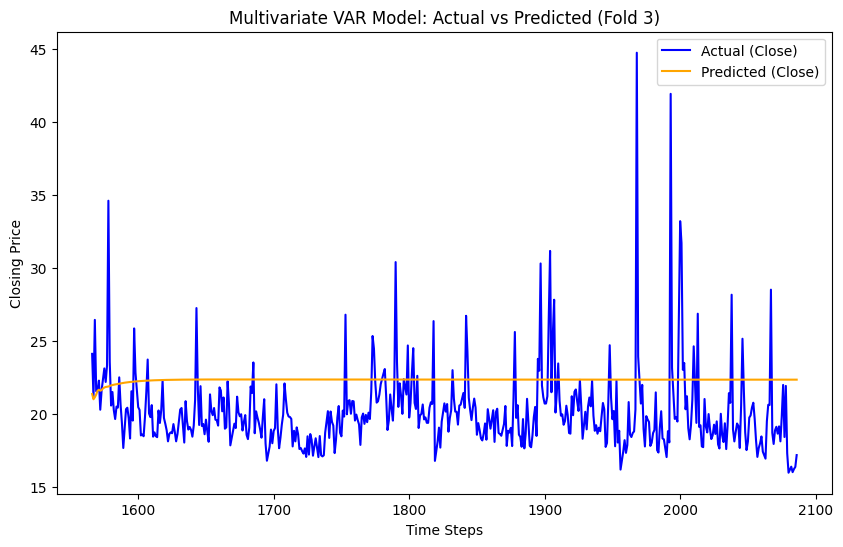

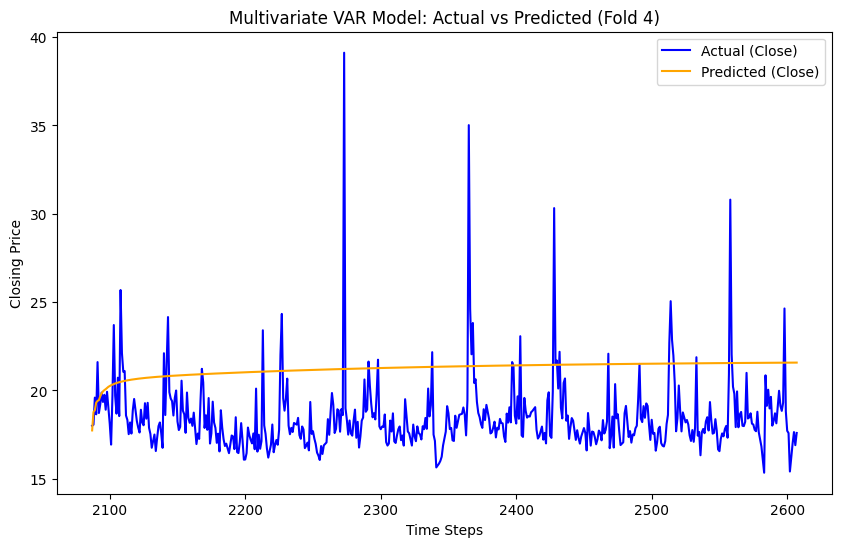

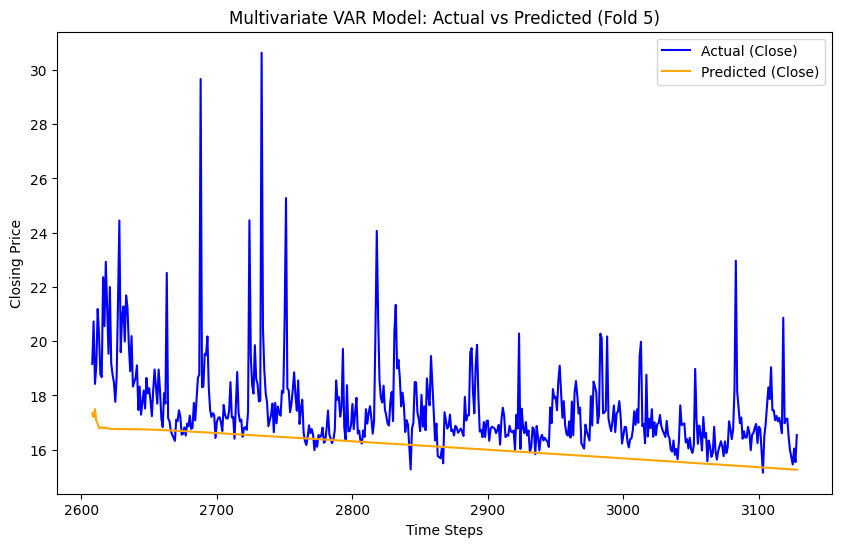

   Fold        MSE      RMSE       MAPE        R2
0     1  18.801845  4.336109  11.146295 -0.106275
1     2  10.289048  3.207655  10.596162 -0.076822
2     3  12.603547  3.550147  15.072120 -0.640022
3     4  12.135471  3.483600  17.425732 -1.879648
4     5   4.214829  2.053005   7.646446 -0.623580


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Separate features and target
features = data.drop(columns=['Close']).values
target = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

normalized_features = scaler_features.fit_transform(features[:, 1:])
normalized_target = scaler_target.fit_transform(target)

# Combine normalized features and target into one DataFrame
normalized_data = np.hstack([normalized_features, normalized_target])
df = pd.DataFrame(normalized_data, columns=[*data.columns[1:]], index=data.index)

# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Store metrics for each fold
metrics = []

for fold, (train_index, test_index) in enumerate(tscv.split(df), 1):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Fit the VAR (Vector AutoRegression) model
    model = VAR(train)
    model_fitted = model.fit(ic='aic')

    # Forecasting
    pred = model_fitted.forecast(y=train.values[-10:], steps=len(test))

    # Extract the predicted values for 'Close'
    predictions = pred[:, df.columns.get_loc('Close')]

    # Inverse transform the predicted and actual 'Close' values
    test_actual = scaler_target.inverse_transform(test['Close'].values.reshape(-1, 1))
    predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1))

    # Calculate metrics
    mse = mean_squared_error(test_actual, predictions)
    mape = mean_absolute_percentage_error(test_actual, predictions) * 100
    rmse = np.sqrt(mse)
    r2 = r2_score(test_actual, predictions)

    # Store metrics for this fold
    metrics.append({
        'Fold': fold,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    })

    # Plot the results for this fold
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test_actual, label='Actual (Close)', color='blue')
    plt.plot(test.index, predictions, label='Predicted (Close)', color='orange')
    plt.xlabel('Time Steps')
    plt.ylabel('Closing Price')
    plt.title(f'Multivariate VAR Model: Actual vs Predicted (Fold {fold})')
    plt.legend()
    plt.show()

# Display metrics for each fold
import pandas as pd
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Data Spitting and Normalization

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
features = data.drop(columns=['Date']).values  # All features except 'Date'. I included Close because I think we need to
target = data['Close'].values.reshape(-1, 1)  # Target column

# Min-Max Scaling
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit and transform
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Sequentially split the dataset into training, validation, and testing sets
train_size = int(len(features_scaled) * 0.6)
val_size = int(len(features_scaled) * 0.2)

train_features = features_scaled[:train_size]
train_target = target_scaled[:train_size]

val_features = features_scaled[train_size:train_size + val_size]
val_target = target_scaled[train_size:train_size + val_size]

test_features = features_scaled[train_size + val_size:]
test_target = target_scaled[train_size + val_size:]

TrainX shape: (1867, 10, 5), TrainY shape: (1867, 1, 1)
ValX shape: (615, 10, 5), ValY shape: (615, 1, 1)
TestX shape: (617, 10, 5), TestY shape: (617, 1, 1)


In [ ]:
def create_sequences(features, target, time_steps=10, forecast_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps - forecast_steps + 1):
        X.append(features[i:i+time_steps])  # Historical input sequence
        y.append(target[i+time_steps:i+time_steps+forecast_steps])  # Future target values
    return np.array(X), np.array(y)


# Generate sequences for each split
trainX, trainY = create_sequences(train_features, train_target, time_steps)
valX, valY = create_sequences(val_features, val_target, time_steps)
testX, testY = create_sequences(test_features, test_target, time_steps)

# Print shapes of generated sequences
print(f"TrainX shape: {trainX.shape}, TrainY shape: {trainY.shape}")
print(f"ValX shape: {valX.shape}, ValY shape: {valY.shape}")
print(f"TestX shape: {testX.shape}, TestY shape: {testY.shape}")

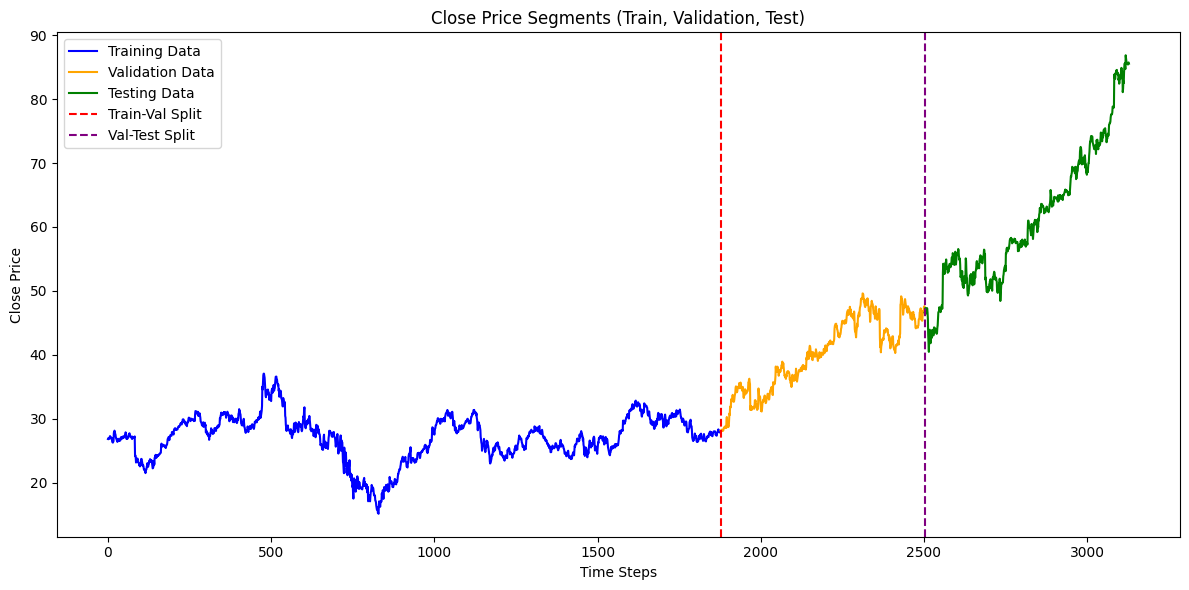

In [ ]:
import matplotlib.pyplot as plt

# Prepare the `Close` data for plotting (inverse scale to original range)
close_scaled = np.concatenate([train_target, val_target, test_target]).flatten()
close_original = scaler_target.inverse_transform(close_scaled.reshape(-1, 1)).flatten()

# Calculate indices for splitting
train_end = len(train_target)
val_end = train_end + len(val_target)

# Create x-values for the plot
time_indices = range(len(close_original))

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(time_indices[:train_end], close_original[:train_end], label='Training Data', color='blue')
plt.plot(time_indices[train_end:val_end], close_original[train_end:val_end], label='Validation Data', color='orange')
plt.plot(time_indices[val_end:], close_original[val_end:], label='Testing Data', color='green')

# Add vertical lines to indicate splits
plt.axvline(x=train_end, color='red', linestyle='--', label='Train-Val Split')
plt.axvline(x=val_end, color='purple', linestyle='--', label='Val-Test Split')

# Add labels, legend, and title
plt.title('Close Price Segments (Train, Validation, Test)')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()


# Stacked RNN model


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0686 - val_loss: 0.0061
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0103 - val_loss: 0.0072
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0054 - val_loss: 0.0025
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 5.5300e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - val_loss: 7.9739e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010 - val_loss: 9.5788e-04
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9288e-04 - 

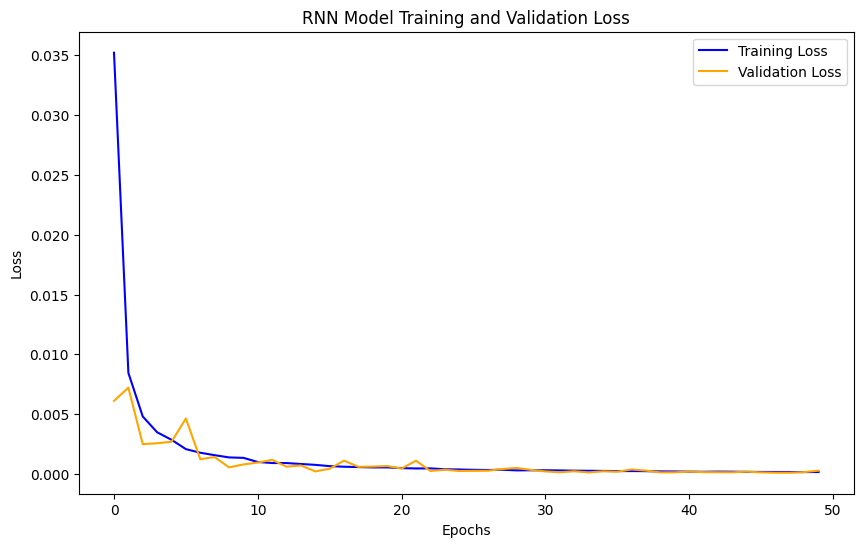

In [ ]:
import time
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Build the RNN model
RNNmodel = Sequential()
RNNmodel.add(SimpleRNN(50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
RNNmodel.add(Dropout(0.2))
RNNmodel.add(SimpleRNN(50))
RNNmodel.add(Dropout(0.2))
RNNmodel.add(Dense(1))

RNNmodel.compile(optimizer='adam', loss='mse')

RNNstart_time = time.time()

# Train the model
history = RNNmodel.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(valX, valY), verbose=1)

RNNtraining_time = time.time() - RNNstart_time
RNNaverage_epoch_time = RNNtraining_time / 50

# Print computational cost
print(f"Total Training Time: {RNNtraining_time:.2f} seconds")
print(f"Average Time per Epoch: {RNNaverage_epoch_time:.2f} seconds")

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions for training and testing (validation) data

y_train_pred = RNNmodel.predict(trainX)
y_test_pred = RNNmodel.predict(testX)


trainY_original = scaler_target.inverse_transform(trainY.reshape(-1, 1)).flatten()
testY_original = scaler_target.inverse_transform(testY.reshape(-1, 1)).flatten()

y_train_pred_original = scaler_target.inverse_transform(y_train_pred).flatten()
y_test_pred_original = scaler_target.inverse_transform(y_test_pred).flatten()


# Use scaled values for metrics
trainY_flat = trainY.flatten()
testY_flat = testY.flatten()
y_train_pred_flat = y_train_pred.flatten()
y_test_pred_flat = y_test_pred.flatten()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mape, r2


# Calculate metrics for training data
mse_train, rmse_train, mape_train, r2_train = calculate_metrics(trainY_original, y_train_pred_original)

# Calculate metrics for testing data
mse_test, rmse_test, mape_test, r2_test = calculate_metrics(testY_original, y_test_pred_original)

print("----- Training Metrics -----")
print(f"MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAPE: {mape_train:.2f}%, R²: {r2_train:.4f}")
print("----- Testing Metrics -----")
print(f"MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAPE: {mape_test:.2f}%, R²: {r2_test:.4f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
----- Training Metrics -----
MSE: 0.3012, RMSE: 0.5488, MAPE: 1.51%, R²: 0.9762
----- Testing Metrics -----
MSE: 17.7204, RMSE: 4.2096, MAPE: 5.66%, R²: 0.8459


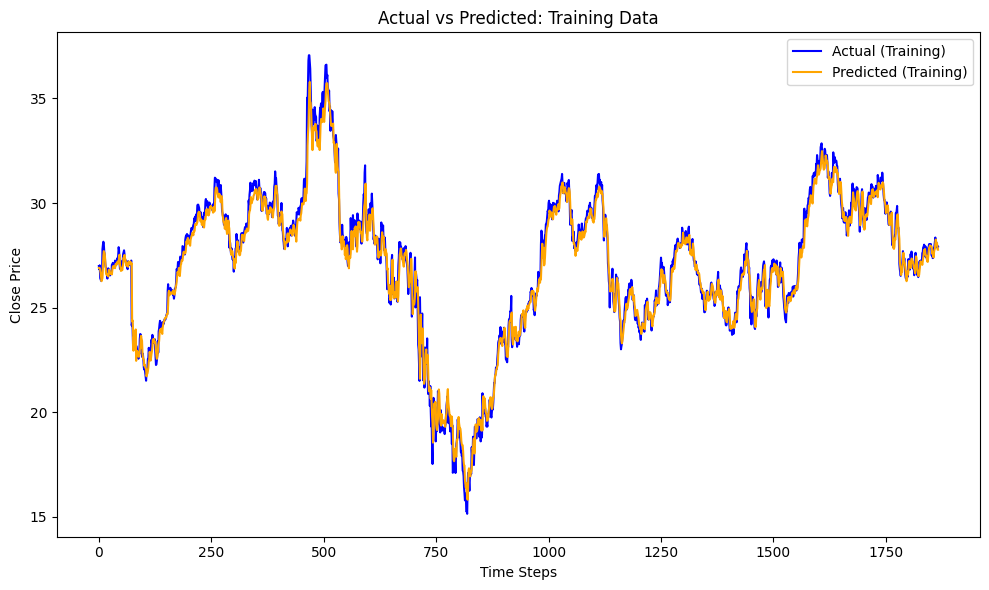

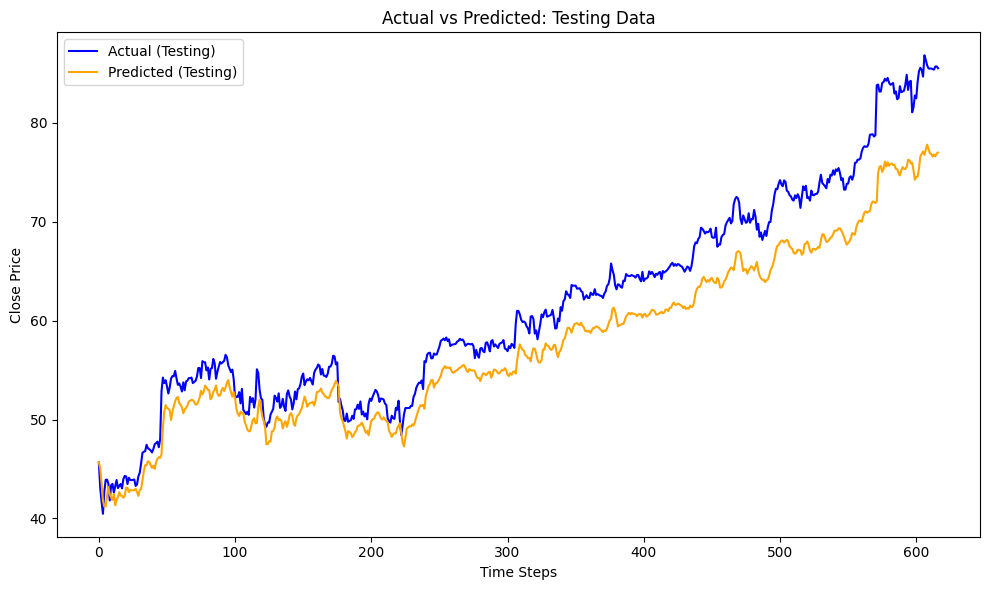

In [ ]:
# Plot Actual vs Predicted for Training Data
plt.figure(figsize=(10, 6))
plt.plot(trainY_original, label='Actual (Training)', color='blue')
plt.plot(y_train_pred_original, label='Predicted (Training)', color='orange')
plt.title('Actual vs Predicted: Training Data')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Actual vs Predicted for Testing Data
plt.figure(figsize=(10, 6))
plt.plot(testY_original, label='Actual (Testing)', color='blue')
plt.plot(y_test_pred_original, label='Predicted (Testing)', color='orange')
plt.title('Actual vs Predicted: Testing Data')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()


# LSTM model

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.0847e-04 - val_loss: 2.8198e-04
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.3009e-04 - val_loss: 3.6584e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8198e-04 - val_loss: 3.6044e-04
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3606e-04 - val_loss: 6.7887e-04
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3351e-04 - val_loss: 5.5052e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0351e-04 - val_loss: 3.6410e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6457e-04 - val_loss: 3.8768e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4762e-04 - val_loss: 4.9770e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3531e-04 - val_loss: 8.0515e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0967e-04 - val_loss: 4.017

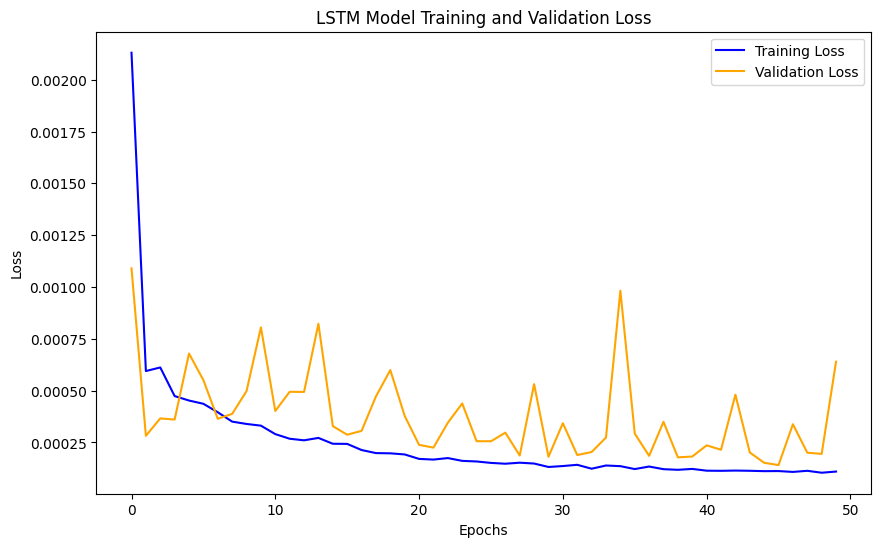

In [ ]:
import time
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score


# Build the RNN model
LSTMmodel = Sequential()
LSTMmodel.add(LSTM(50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(LSTM(25))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(1))

LSTMmodel.compile(optimizer='adam', loss='mse')

LSTMstart_time = time.time()

# Train the model
history = LSTMmodel.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(valX, valY), verbose=1)

LSTMtraining_time = time.time() - LSTMstart_time
LSTMaverage_epoch_time = LSTMtraining_time / 50

# Print computational cost
print(f"Total Training Time: {LSTMtraining_time:.2f} seconds")
print(f"Average Time per Epoch: {LSTMaverage_epoch_time:.2f} seconds")


# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions for training and testing (validation) data

y_train_pred = LSTMmodel.predict(trainX)
y_test_pred = LSTMmodel.predict(testX)


trainY_original = scaler_target.inverse_transform(trainY.reshape(-1, 1)).flatten()
testY_original = scaler_target.inverse_transform(testY.reshape(-1, 1)).flatten()

y_train_pred_original = scaler_target.inverse_transform(y_train_pred).flatten()
y_test_pred_original = scaler_target.inverse_transform(y_test_pred).flatten()


# Use scaled values for metrics
trainY_flat = trainY.flatten()
testY_flat = testY.flatten()
y_train_pred_flat = y_train_pred.flatten()
y_test_pred_flat = y_test_pred.flatten()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mape, r2


# Calculate metrics for training data
mse_train, rmse_train, mape_train, r2_train = calculate_metrics(trainY_original, y_train_pred_original)

# Calculate metrics for testing data
mse_test, rmse_test, mape_test, r2_test = calculate_metrics(testY_original, y_test_pred_original)

print("----- Training Metrics -----")
print(f"MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAPE: {mape_train:.2f}%, R²: {r2_train:.4f}")
print("----- Testing Metrics -----")
print(f"MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAPE: {mape_test:.2f}%, R²: {r2_test:.4f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
----- Training Metrics -----
MSE: 0.4274, RMSE: 0.6538, MAPE: 1.88%, R²: 0.9662
----- Testing Metrics -----
MSE: 24.4153, RMSE: 4.9412, MAPE: 7.17%, R²: 0.7876


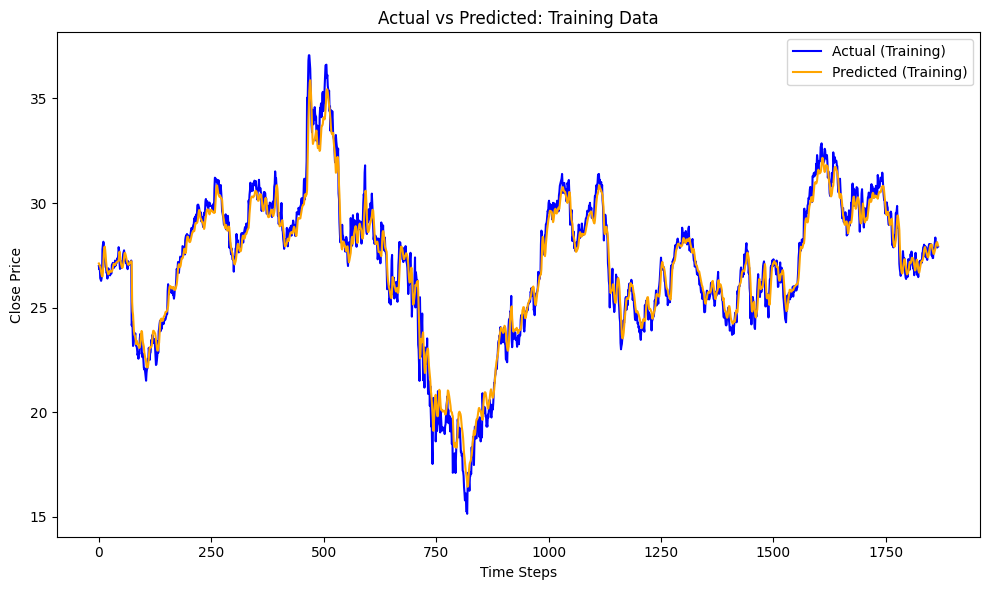

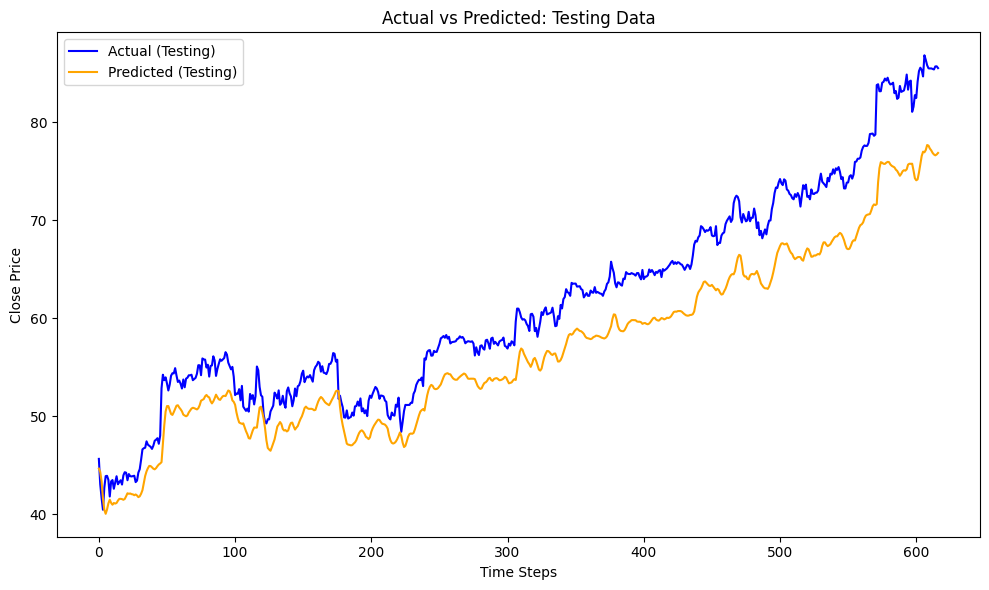

In [ ]:
# Plot Actual vs Predicted for Training Data
plt.figure(figsize=(10, 6))
plt.plot(trainY_original, label='Actual (Training)', color='blue')
plt.plot(y_train_pred_original, label='Predicted (Training)', color='orange')
plt.title('Actual vs Predicted: Training Data')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Actual vs Predicted for Testing Data
plt.figure(figsize=(10, 6))
plt.plot(testY_original, label='Actual (Testing)', color='blue')
plt.plot(y_test_pred_original, label='Predicted (Testing)', color='orange')
plt.title('Actual vs Predicted: Testing Data')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

# Transformer model

Epoch 1, Train Loss: 0.0326
Epoch 2, Train Loss: 0.0044
Epoch 3, Train Loss: 0.0018
Epoch 4, Train Loss: 0.0012
Epoch 5, Train Loss: 0.0010
Epoch 6, Train Loss: 0.0008
Epoch 7, Train Loss: 0.0008
Epoch 8, Train Loss: 0.0007
Epoch 9, Train Loss: 0.0007
Epoch 10, Train Loss: 0.0006
Epoch 11, Train Loss: 0.0006
Epoch 12, Train Loss: 0.0006
Epoch 13, Train Loss: 0.0005
Epoch 14, Train Loss: 0.0005
Epoch 15, Train Loss: 0.0005
Epoch 16, Train Loss: 0.0005
Epoch 17, Train Loss: 0.0005
Epoch 18, Train Loss: 0.0005
Epoch 19, Train Loss: 0.0004
Epoch 20, Train Loss: 0.0004
Test Loss: 0.0091


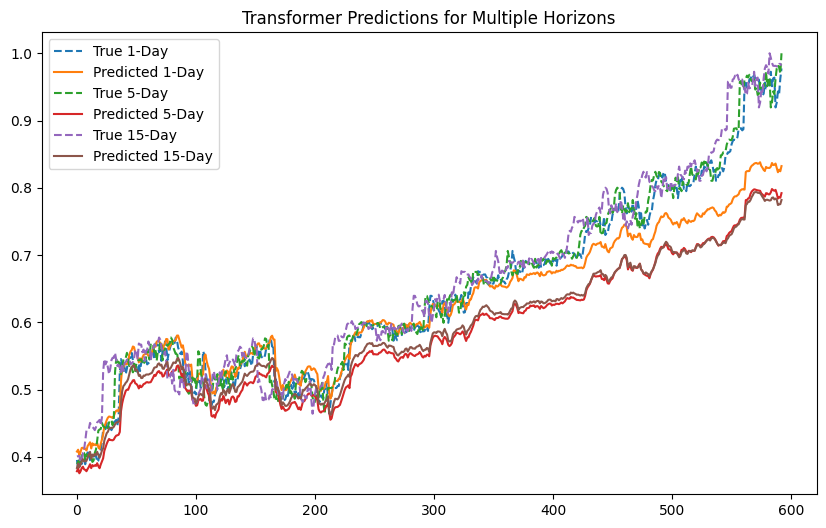


Metrics for 1-Day Forecast:
Root Mean Squared Error (RMSE): 0.0415
Mean Absolute Error (MAE): 0.0275
R² Score: 0.9114

Metrics for 5-Day Forecast:
Root Mean Squared Error (RMSE): 0.0772
Mean Absolute Error (MAE): 0.0647
R² Score: 0.6991

Metrics for 15-Day Forecast:
Root Mean Squared Error (RMSE): 0.0868
Mean Absolute Error (MAE): 0.0704
R² Score: 0.6339


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import torch

# Set random seeds for reproducibility
seed = 57
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
inp_features = 5

# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32).squeeze(-1)  # Squeeze last dimension for compatibility

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

train_dataset = TimeSeriesDataset(trainX, trainY)
val_dataset = TimeSeriesDataset(valX, valY)
test_dataset = TimeSeriesDataset(testX, testY)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define TransformerLayer
class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(embed_dim=D, num_heads=H, dropout=dropout_rate, batch_first=True)
        self.norm1 = nn.LayerNorm(D)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.feedforward = nn.Sequential(
            nn.Linear(D, hidden_mlp_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_mlp_dim, D)
        )
        self.norm2 = nn.LayerNorm(D)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x, mask=None):
        attn_output, _ = self.self_attention(x, x, x, attn_mask=mask)
        x = self.norm1(x + self.dropout1(attn_output))
        feedforward_output = self.feedforward(x)
        x = self.norm2(x + self.dropout2(feedforward_output))
        return x

# Custom Transformer Model with updated parameters
class Transformer(nn.Module):
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D)
        self.output_projection = nn.Linear(D, out_features)
        self.pos_encoding = self.create_positional_encoding(D, time_steps)
        self.layers = nn.ModuleList([
            TransformerLayer(D, H, hidden_mlp_dim, dropout_rate) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout_rate)

    def create_positional_encoding(self, D, max_len):
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, D, 2) * -(math.log(10000.0) / D))
        pe = torch.zeros(max_len, D)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x, mask=None):
        x = self.input_projection(x) + self.pos_encoding[:, :x.size(1), :]
        for layer in self.layers:
            x = layer(x, mask)
        x = self.output_projection(x[:, -1, :])  # Predict for all future steps
        return x


# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(
    num_layers=2,               # Encoder depth
    D=128,                      # Hidden size
    H=4,                        # Encoder heads
    hidden_mlp_dim=128,         # Embedding size
    inp_features=inp_features,  # Input size (number of features)
    out_features=future_steps,  # Number of future steps to predict
    dropout_rate=0.2            # Dropout rate
).to(device)

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)  # Output shape: [batch_size, future_steps]
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}")


# Evaluation
model.eval()
test_loss = 0.0
predictions, true_values = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
        predictions.append(outputs.cpu().numpy())
        true_values.append(targets.cpu().numpy())

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

# Plot predictions for 1, 5, and 15-day horizons
predictions = np.concatenate(predictions)
true_values = np.concatenate(true_values)


# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mape, r2


# Calculate metrics for testing data
mse_test, rmse_test, mape_test, r2_test = calculate_metrics(true_values, predictions)
print("----- Testing Metrics -----")
print(f"MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAPE: {mape_test:.2f}%, R²: {r2_test:.4f}")

# Forecasting Power

RNN model

Evaluating combination: time_steps=10, forecast_steps=1
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1380 - val_loss: 0.0017
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0141 - val_loss: 0.0024
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0074 - val_loss: 0.0018
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0029
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 4.1043e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - val_loss: 4.6787e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - val_loss: 3.9578e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_

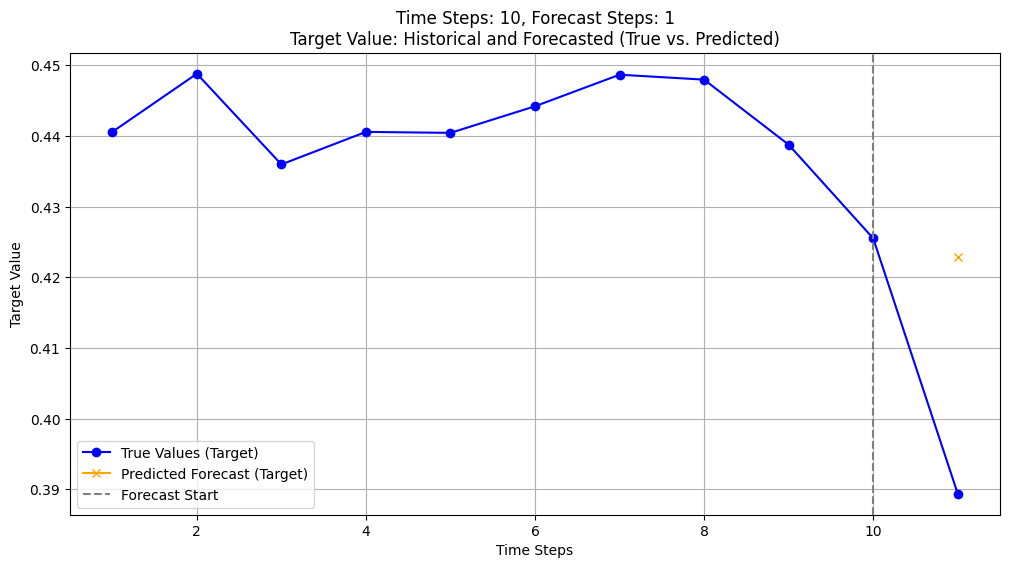

Evaluating combination: time_steps=20, forecast_steps=5
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1956 - val_loss: 0.0112
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0210 - val_loss: 0.0120
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0103 - val_loss: 0.0057
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_l

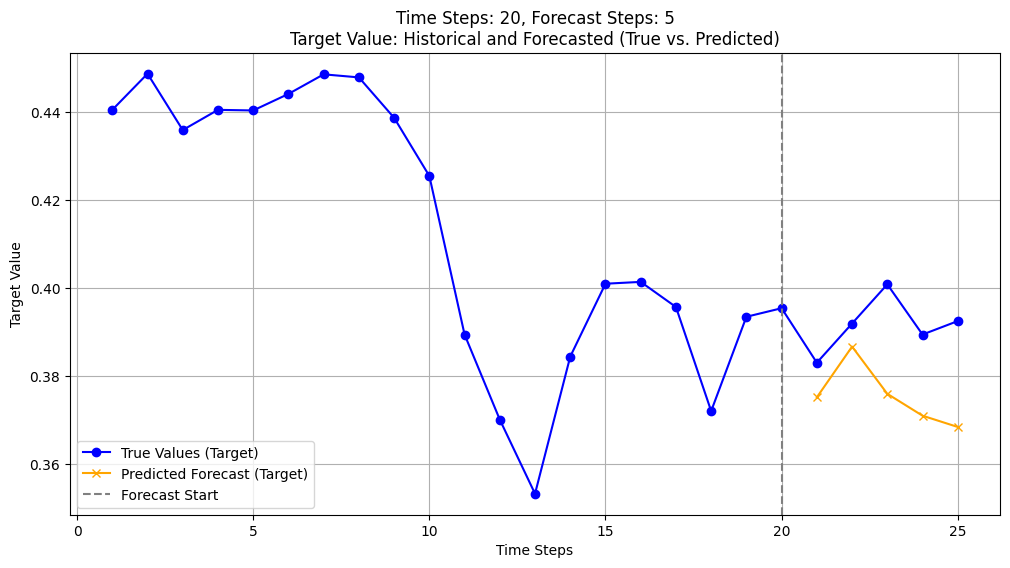

Evaluating combination: time_steps=30, forecast_steps=7
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0964 - val_loss: 0.0154
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0142 - val_loss: 0.0092
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0051 - val_loss: 0.0066
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_l

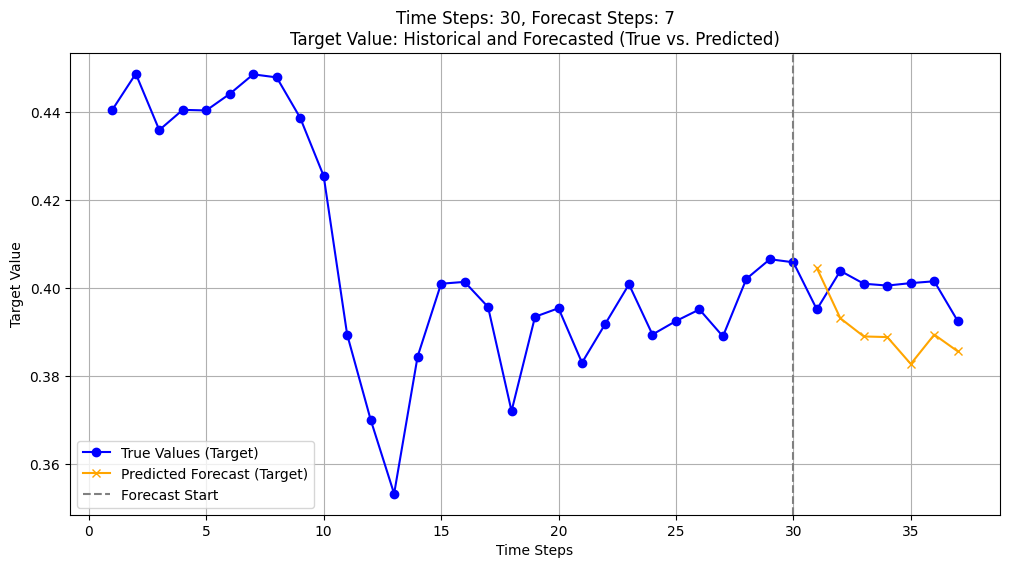

Evaluating combination: time_steps=50, forecast_steps=12
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1291 - val_loss: 0.0183
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0167 - val_loss: 0.0092
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0077 - val_loss: 0.0062
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_l

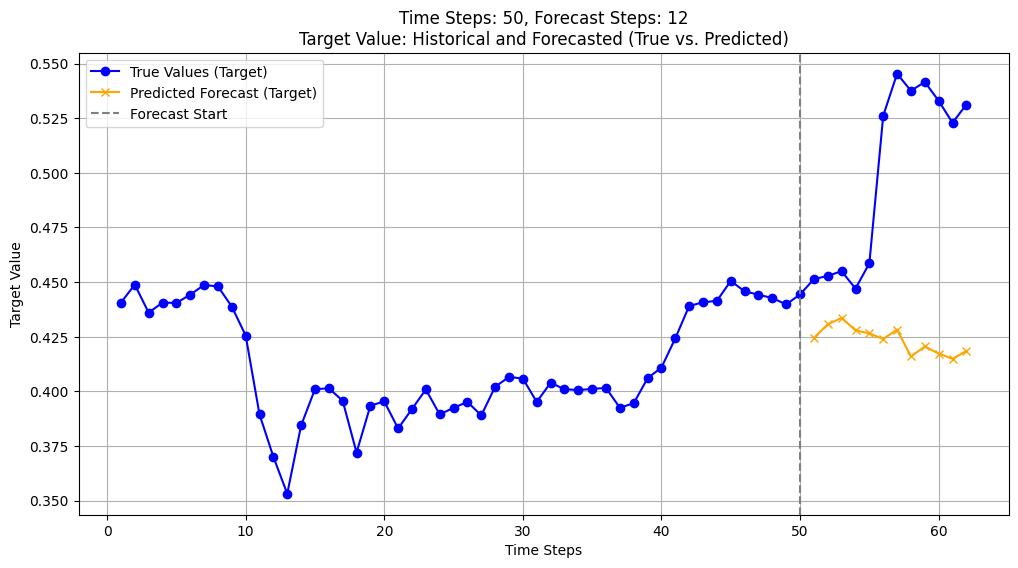


Summary Table:
   time_steps  forecast_steps  rmse_test   r2_test  training_time  \
0          10               1   0.042993  0.917344      32.668720   
1          20               5   0.067811  0.782929      55.119659   
2          30               7   0.062186  0.809127      67.425282   
3          50              12   0.069671  0.741207     102.258129   

   average_epoch_time  
0            0.653374  
1            1.102393  
2            1.348506  
3            2.045163  


In [ ]:
import time
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Define combinations of history (time_steps) and forecast (forecast_steps)
combinations = [
    (10, 1),  # 10 back, 1 predict
    (20, 5),  # 20 back, 5 predict
    (30, 7),  # 30 back, 10 predict
    (50, 12)   # 60 back, 15 predict
]

# Initialize a DataFrame to store results
results = []

# Loop through each combination
for time_steps, forecast_steps in combinations:
    print(f"Evaluating combination: time_steps={time_steps}, forecast_steps={forecast_steps}")

    # Generate sequences for the current combination
    trainX, trainY = create_sequences(train_features, train_target, time_steps, forecast_steps)
    valX, valY = create_sequences(val_features, val_target, time_steps, forecast_steps)
    testX, testY = create_sequences(test_features, test_target, time_steps, forecast_steps)

    # Squeeze the last dimension to remove singleton axis
    trainY = trainY.squeeze(-1)
    valY = valY.squeeze(-1)
    testY = testY.squeeze(-1)


    RNNmodel = Sequential()
    RNNmodel.add(SimpleRNN(50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    RNNmodel.add(Dropout(0.2))
    RNNmodel.add(SimpleRNN(50))
    RNNmodel.add(Dropout(0.2))
    RNNmodel.add(Dense(forecast_steps))
    RNNmodel.compile(optimizer='adam', loss='mse')

    RNNstart_time = time.time()

    # Train the model
    history = RNNmodel.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(valX, valY), verbose=1)

    RNNtraining_time = time.time() - RNNstart_time
    RNNaverage_epoch_time = RNNtraining_time / 50

    # Evaluate on test set
    y_test_pred = RNNmodel.predict(testX)
    rmse_test = np.sqrt(mean_squared_error(testY, y_test_pred))
    r2_test = r2_score(testY, y_test_pred)

    # Save metrics
    results.append({
        "time_steps": time_steps,
        "forecast_steps": forecast_steps,
        "rmse_test": rmse_test,
        "r2_test": r2_test,
        "training_time": RNNtraining_time,
        "average_epoch_time": RNNaverage_epoch_time
    })

    print(f"RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")


    # Visualization for this combination
    sample_index = 1  # Choose a specific index from the test set
    target_idx = 3  # Target column index
    history = testX[sample_index]  # Shape: (time_steps, features)
    true_forecast = testY[sample_index]  # Shape: (forecast_steps,)
    predicted_forecast = y_test_pred[sample_index]

    # Concatenate historical and forecasted true values
    true_values = list(history[:, target_idx]) + list(true_forecast)  # Combine history and true forecast

    # Plot the historical and forecasted target values
    plt.figure(figsize=(12, 6))

    n = time_steps + forecast_steps
    # Plot true values (continuous)
    plt.plot(range(1, n + 1), true_values, label='True Values (Target)', color='blue', marker='o')

    # Plot predicted forecasted values
    plt.plot(range(time_steps + 1, n + 1), predicted_forecast, label='Predicted Forecast (Target)', color='orange', marker='x')

    # Add labels, legend, and title
    plt.xlabel('Time Steps')
    plt.ylabel('Target Value')
    plt.title(f'Time Steps: {time_steps}, Forecast Steps: {forecast_steps}\nTarget Value: Historical and Forecasted (True vs. Predicted)')
    plt.axvline(x=time_steps, color='gray', linestyle='--', label='Forecast Start')  # Separate history from forecast
    plt.legend()
    plt.grid()
    plt.show()

# Convert results to a DataFrame
RNNresults_df = pd.DataFrame(results)

# Save or display the table
print("\nSummary Table:")
print(RNNresults_df)

LSTM model

Evaluating combination: time_steps=10, forecast_steps=1
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0059 - val_loss: 0.0015
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.2949e-04 - val_loss: 3.0035e-04
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.6886e-04 - val_loss: 2.6482e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.9437e-04 - val_loss: 3.2423e-04
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.2060e-04 - val_loss: 3.1030e-04
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.0557e-04 - val_loss: 2.8125e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.2285e-04 - val_loss: 5.4157e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9413e-04 - val_loss: 2.4331e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.7304e-04 - val_loss: 2.8454e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6448e-04 - val_loss: 5.7897e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.5138e-04 - val_loss: 5.447

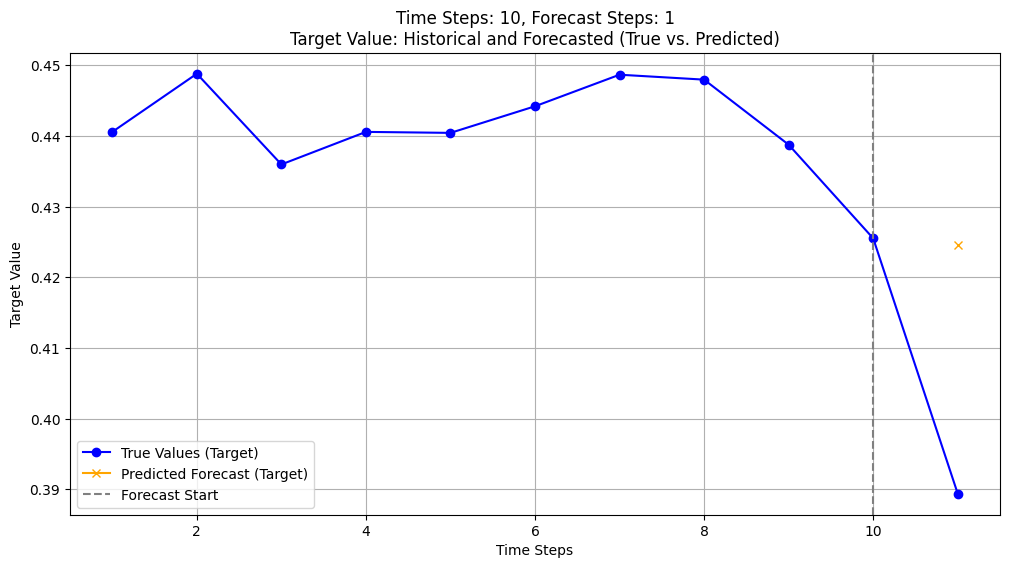

Evaluating combination: time_steps=20, forecast_steps=5
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0076 - val_loss: 0.0033
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.7845e-04 - val_loss: 5.3588e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.6359e-04 - val_loss: 6.3241e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.7202e-04 - val_loss: 6.1503e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.7952e-04 - val_loss: 4.2218e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.0759e-04 - val_loss: 4.9022e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.8794e-04 - val_loss: 8.0245e-04
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.3643e-04 - val_loss: 0.0013
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.2395e-04 - val_loss: 4.7147e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.8740e-04 - val_loss: 4.2271e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.6748e-04 - val_loss: 4.1950e-0

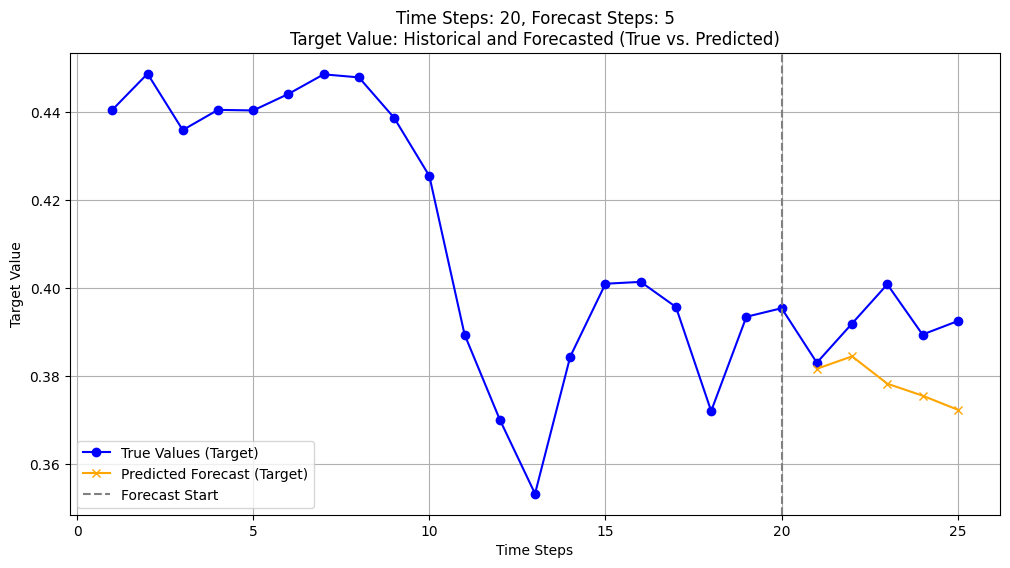

Evaluating combination: time_steps=30, forecast_steps=7
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0065 - val_loss: 0.0018
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.7975e-04 - val_loss: 0.0016
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 7.9778e-04 - val_loss: 7.1577e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.7175e-04 - val_loss: 5.7908e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.6936e-04 - val_loss: 4.3859e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.2728e-04 - val_loss: 9.9216e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.1410e-04 - val_loss: 0.0011
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.4443e-04 - val_loss: 0.0018
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 4.1127e-04 - val_loss: 6.3241e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.9209e-04 - val_loss: 7.2033e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.6329e-04 - val_loss: 7.7686e-04
Epoch 

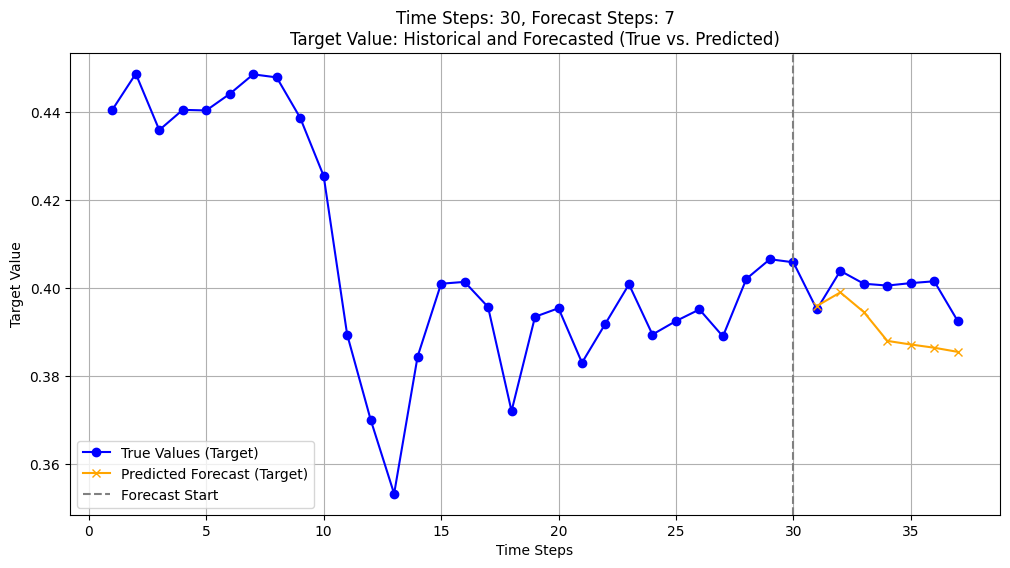

Evaluating combination: time_steps=50, forecast_steps=12
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0123 - val_loss: 0.0037
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 9.3788e-04 - val_loss: 0.0018
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 7.5295e-04 - val_loss: 9.2888e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.9031e-04 - val_loss: 0.0015
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 6.1417e-04 - val_loss: 0.0016
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 5.2618e-04 - val_loss: 9.2670e-04
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.4340e-04 - val_loss: 0.0023
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 4.6574e-04 - val_loss: 0.0011
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 4.6776e-04 - val_loss: 0.0019
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━

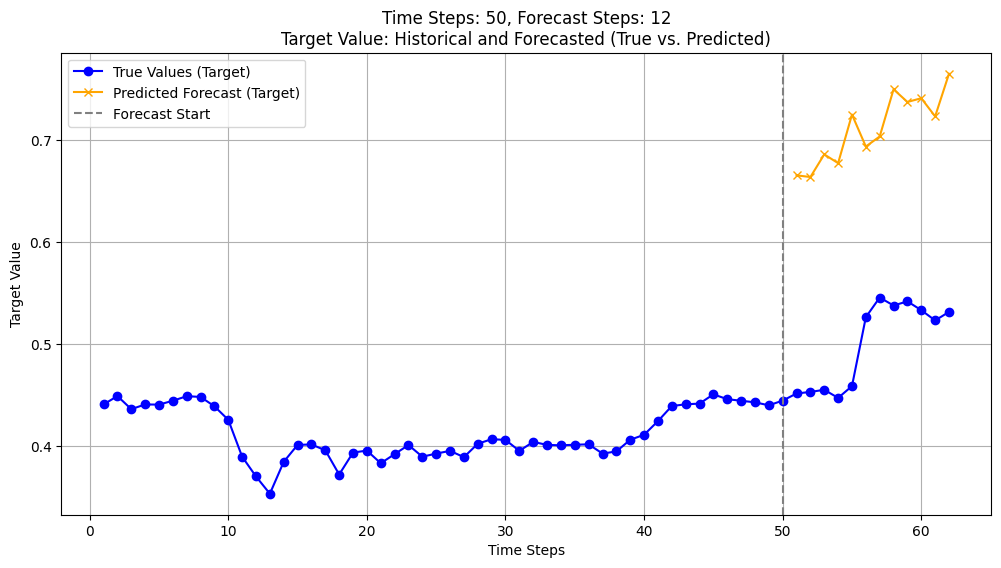


Summary Table:
   time_steps  forecast_steps  rmse_test    r2_test  training_time  \
0          10               1   0.036159   0.941534      60.178102   
1          20               5   0.052629   0.869457      78.208816   
2          30               7   0.057693   0.835984     122.729656   
3          50              12   0.461979 -10.402054     196.827554   

   average_epoch_time  
0            1.203562  
1            1.564176  
2            2.454593  
3            3.936551  


In [ ]:
import time
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from keras.callbacks import ReduceLROnPlateau

# Define combinations of history (time_steps) and forecast (forecast_steps)
combinations = [
    (10, 1),  # 10 back, 1 predict
    (20, 5),  # 20 back, 5 predict
    (30, 7),  # 30 back, 10 predict
    (50, 12)   # 60 back, 15 predict
]

# Initialize a DataFrame to store results
results = []

# Loop through each combination
for time_steps, forecast_steps in combinations:
    print(f"Evaluating combination: time_steps={time_steps}, forecast_steps={forecast_steps}")

    # Generate sequences for the current combination
    trainX, trainY = create_sequences(train_features, train_target, time_steps, forecast_steps)
    valX, valY = create_sequences(val_features, val_target, time_steps, forecast_steps)
    testX, testY = create_sequences(test_features, test_target, time_steps, forecast_steps)

    # Squeeze the last dimension to remove singleton axis
    trainY = trainY.squeeze(-1)
    valY = valY.squeeze(-1)
    testY = testY.squeeze(-1)


    # Build the LSTM model
    LSTMmodel = Sequential()
    LSTMmodel.add(LSTM(50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    LSTMmodel.add(Dropout(0.2))
    LSTMmodel.add(LSTM(50, return_sequences=False))
    LSTMmodel.add(Dropout(0.2))
    LSTMmodel.add(Dense(forecast_steps))

    LSTMmodel.compile(optimizer='adam', loss='mse')

    LSTMstart_time = time.time()

    # Train the model
    #lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    history = LSTMmodel.fit(
        trainX, trainY, epochs=50, batch_size=32, validation_data=(valX, valY), verbose=1, )#callbacks=[lr_scheduler])

    LSTMtraining_time = time.time() - LSTMstart_time
    LSTMaverage_epoch_time = LSTMtraining_time / 50

    # Evaluate on test set
    y_test_pred = LSTMmodel.predict(testX)
    rmse_test = np.sqrt(mean_squared_error(testY, y_test_pred))
    r2_test = r2_score(testY, y_test_pred)

    # Save metrics
    results.append({
        "time_steps": time_steps,
        "forecast_steps": forecast_steps,
        "rmse_test": rmse_test,
        "r2_test": r2_test,
        "training_time": LSTMtraining_time,
        "average_epoch_time": LSTMaverage_epoch_time
    })

    print(f"RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")


    # Visualization for this combination
    sample_index = 1  # Choose a specific index from the test set
    target_idx = 3  # Target column index
    history = testX[sample_index]  # Shape: (time_steps, features)
    true_forecast = testY[sample_index]  # Shape: (forecast_steps,)
    predicted_forecast = y_test_pred[sample_index]

    # Concatenate historical and forecasted true values
    true_values = list(history[:, target_idx]) + list(true_forecast)  # Combine history and true forecast

    # Plot the historical and forecasted target values
    plt.figure(figsize=(12, 6))

    n = time_steps + forecast_steps
    # Plot true values (continuous)
    plt.plot(range(1, n + 1), true_values, label='True Values (Target)', color='blue', marker='o')

    # Plot predicted forecasted values
    plt.plot(range(time_steps + 1, n + 1), predicted_forecast, label='Predicted Forecast (Target)', color='orange', marker='x')

    # Add labels, legend, and title
    plt.xlabel('Time Steps')
    plt.ylabel('Target Value')
    plt.title(f'Time Steps: {time_steps}, Forecast Steps: {forecast_steps}\nTarget Value: Historical and Forecasted (True vs. Predicted)')
    plt.axvline(x=time_steps, color='gray', linestyle='--', label='Forecast Start')  # Separate history from forecast
    plt.legend()
    plt.grid()
    plt.show()

# Convert results to a DataFrame
LSTMresults_df = pd.DataFrame(results)

# Save or display the table
print("\nSummary Table:")
print(LSTMresults_df)

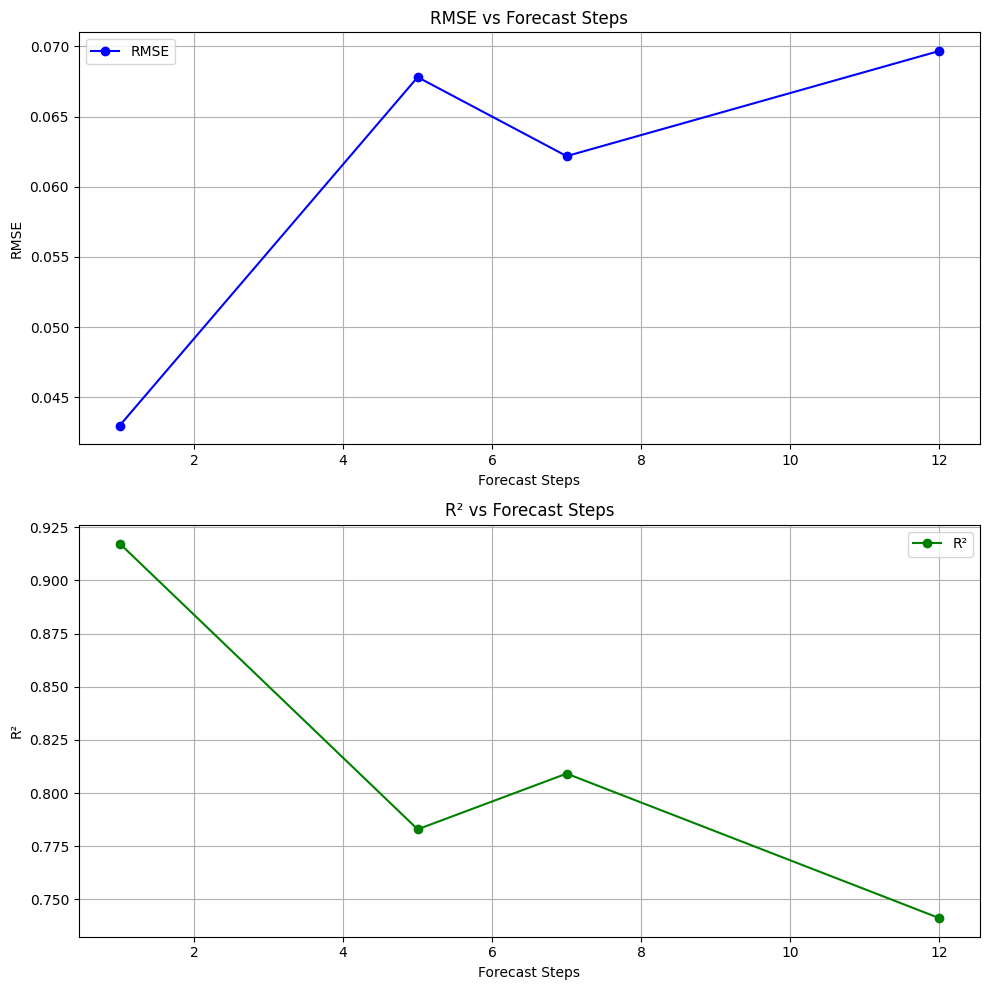

In [ ]:
# Extract values from the DataFrame
forecast_steps = RNNresults_df["forecast_steps"]
rmse_test = RNNresults_df["rmse_test"]
r2_test = RNNresults_df["r2_test"]

# Create the subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot RMSE vs Forecast Steps
axs[0].plot(forecast_steps, rmse_test, marker='o', color='blue', label='RMSE')
axs[0].set_title('RMSE vs Forecast Steps')
axs[0].set_xlabel('Forecast Steps')
axs[0].set_ylabel('RMSE')
axs[0].grid(True)
axs[0].legend()

# Plot R² vs Forecast Steps
axs[1].plot(forecast_steps, r2_test, marker='o', color='green', label='R²')
axs[1].set_title('R² vs Forecast Steps')
axs[1].set_xlabel('Forecast Steps')
axs[1].set_ylabel('R²')
axs[1].grid(True)
axs[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


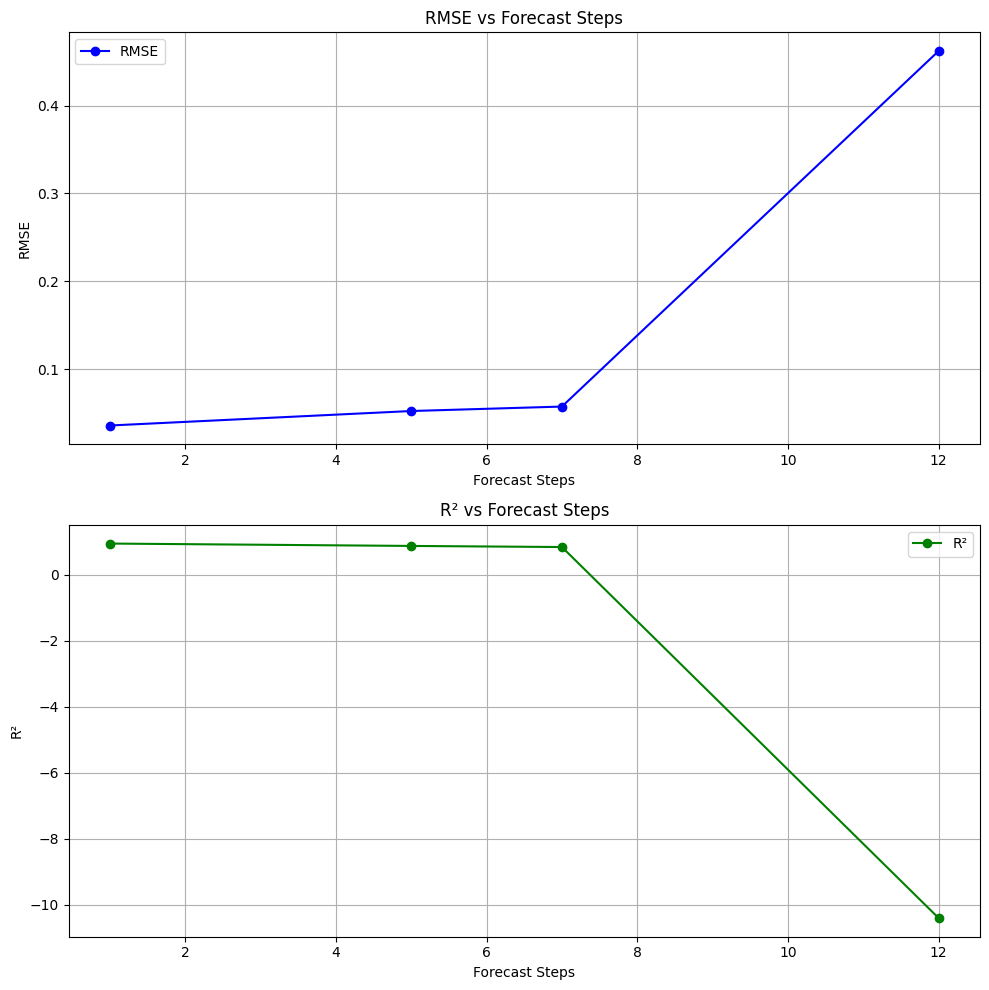

In [ ]:
# Extract values from the DataFrame
forecast_steps = LSTMresults_df["forecast_steps"]
rmse_test = LSTMresults_df["rmse_test"]
r2_test = LSTMresults_df["r2_test"]

# Create the subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot RMSE vs Forecast Steps
axs[0].plot(forecast_steps, rmse_test, marker='o', color='blue', label='RMSE')
axs[0].set_title('RMSE vs Forecast Steps')
axs[0].set_xlabel('Forecast Steps')
axs[0].set_ylabel('RMSE')
axs[0].grid(True)
axs[0].legend()

# Plot R² vs Forecast Steps
axs[1].plot(forecast_steps, r2_test, marker='o', color='green', label='R²')
axs[1].set_title('R² vs Forecast Steps')
axs[1].set_xlabel('Forecast Steps')
axs[1].set_ylabel('R²')
axs[1].grid(True)
axs[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

Transformer

Epoch 1/20, Train Loss: 0.2045, Val R²: -2.6297
Epoch 2/20, Train Loss: 0.0112, Val R²: -2.5568
Epoch 3/20, Train Loss: 0.0068, Val R²: -0.8681
Epoch 4/20, Train Loss: 0.0057, Val R²: -0.0321
Epoch 5/20, Train Loss: 0.0044, Val R²: 0.8249
Epoch 6/20, Train Loss: 0.0032, Val R²: 0.9578
Epoch 7/20, Train Loss: 0.0024, Val R²: 0.9708
Epoch 8/20, Train Loss: 0.0023, Val R²: 0.9695
Epoch 9/20, Train Loss: 0.0019, Val R²: 0.9238
Epoch 10/20, Train Loss: 0.0017, Val R²: 0.8101
Epoch 11/20, Train Loss: 0.0015, Val R²: 0.9666
Epoch 12/20, Train Loss: 0.0013, Val R²: 0.9322
Epoch 13/20, Train Loss: 0.0011, Val R²: 0.9706
Epoch 14/20, Train Loss: 0.0010, Val R²: 0.9666
Epoch 15/20, Train Loss: 0.0012, Val R²: 0.9146
Epoch 16/20, Train Loss: 0.0009, Val R²: 0.9673
Epoch 17/20, Train Loss: 0.0008, Val R²: 0.8974
Epoch 18/20, Train Loss: 0.0008, Val R²: 0.9659
Epoch 19/20, Train Loss: 0.0008, Val R²: 0.8792
Epoch 20/20, Train Loss: 0.0008, Val R²: 0.9670
Configuration: History 10, Predictions 1 Test

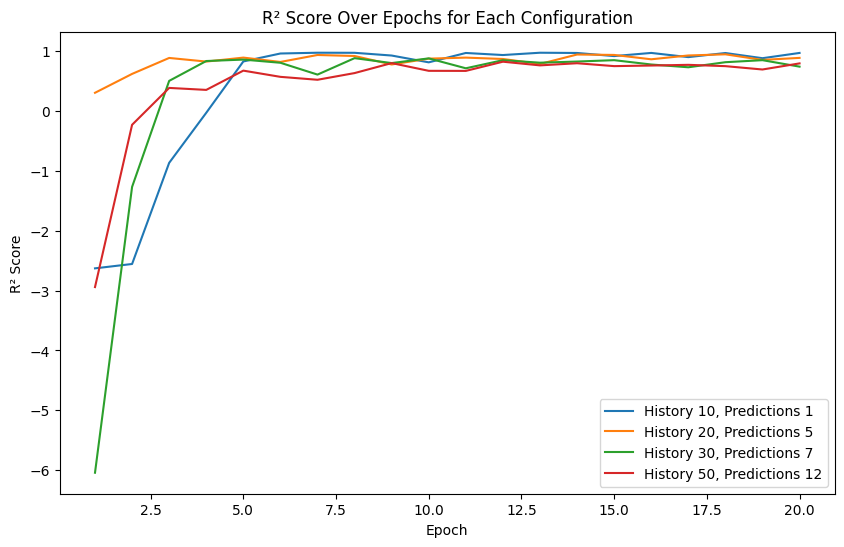

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import math
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import time

# Set random seeds for reproducibility
seed = 57
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load data
data = pd.read_csv("MSFT_2006-01-01_to_2018-01-01.csv")
data = data.iloc[:, :-1]  # Remove last column
data["Date"] = pd.to_datetime(data["Date"])

# Missing weekday handling
full_date_range = pd.date_range(start='2006-01-03', end='2017-12-29', freq='B')  # Business days only
missing_dates = full_date_range.difference(data["Date"])
for missing_date in missing_dates:
    prev_date = data[data["Date"] < missing_date]["Date"].max()
    next_date = data[data["Date"] > missing_date]["Date"].min()
    avg_row = data.loc[data["Date"].isin([prev_date, next_date])].mean(numeric_only=True)
    avg_row["Date"] = missing_date
    data = pd.concat([data, pd.DataFrame([avg_row])], ignore_index=True)
data.sort_values(by="Date", inplace=True)

# Normalization
features = data.drop(columns=["Date"]).values
target = data["Close"].values.reshape(-1, 1)

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Sequence generation
def create_sequences(data, target, time_steps=20, future_steps=15):
    X, y = [], []
    for i in range(len(data) - time_steps - future_steps + 1):
        X.append(data[i:i + time_steps])
        y.append(target[i + time_steps:i + time_steps + future_steps])
    return np.array(X), np.array(y)

# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32).squeeze(-1)  # Squeeze last dimension for compatibility

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Model class
class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(embed_dim=D, num_heads=H, dropout=dropout_rate, batch_first=True)
        self.norm1 = nn.LayerNorm(D)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.feedforward = nn.Sequential(
            nn.Linear(D, hidden_mlp_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_mlp_dim, D)
        )
        self.norm2 = nn.LayerNorm(D)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x, mask=None):
        attn_output, _ = self.self_attention(x, x, x, attn_mask=mask)
        x = self.norm1(x + self.dropout1(attn_output))
        feedforward_output = self.feedforward(x)
        x = self.norm2(x + self.dropout2(feedforward_output))
        return x

# Custom Transformer Model
class Transformer(nn.Module):
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate, max_len):
        super(Transformer, self).__init__()
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D)
        self.output_projection = nn.Linear(D, out_features)
        self.pos_encoding = self.create_positional_encoding(D, max_len)
        self.layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim, dropout_rate) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def create_positional_encoding(self, D, max_len):
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, D, 2) * -(math.log(10000.0) / D))
        pe = torch.zeros(max_len, D)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x, mask=None):
        x = self.input_projection(x) + self.pos_encoding[:, :x.size(1), :]
        for layer in self.layers:
            x = layer(x, mask)
        x = self.output_projection(x[:, -1, :])  # Predict for all future steps
        return x

# Loop over multiple configurations
configurations = [
    {"history": 10, "predictions": 1},
    {"history": 20, "predictions": 5},
    {"history": 30, "predictions": 7},
    {"history": 50, "predictions": 12}
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# To store metrics
train_losses = {}
test_rmse = {}
test_r2 = {}
r2_scores_over_epochs = {}

# Train-validation-test split
train_size = int(len(features_scaled) * 0.6)
val_size = int(len(features_scaled) * 0.2)
test_size = len(features_scaled) - train_size - val_size

for config in configurations:
    history = config["history"]
    future = config["predictions"]
    r2_scores_over_epochs[f"History {history}, Predictions {future}"] = []

    trainX, trainY = create_sequences(features_scaled[:train_size], target_scaled[:train_size], time_steps=history, future_steps=future)
    valX, valY = create_sequences(features_scaled[train_size:train_size + val_size], target_scaled[train_size:train_size + val_size], time_steps=history, future_steps=future)
    testX, testY = create_sequences(features_scaled[train_size + val_size:], target_scaled[train_size + val_size:], time_steps=history, future_steps=future)

    train_dataset = TimeSeriesDataset(trainX, trainY)
    val_dataset = TimeSeriesDataset(valX, valY)
    test_dataset = TimeSeriesDataset(testX, testY)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model = Transformer(
        num_layers=2,
        D=128,
        H=4,
        hidden_mlp_dim=128,
        inp_features=5,
        out_features=future,
        dropout_rate=0.2,
        max_len=max(config["history"], 50)
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    num_epochs = 20
    epoch_losses = []
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        epoch_loss = train_loss / len(train_loader)
        epoch_losses.append(epoch_loss)

        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_preds.append(outputs.cpu().numpy())
                val_targets.append(targets.cpu().numpy())
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        epoch_r2 = r2_score(val_targets, val_preds)
        r2_scores_over_epochs[f"History {history}, Predictions {future}"].append(epoch_r2)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val R²: {epoch_r2:.4f}")

    # Evaluation
    test_preds, test_targets = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_preds.append(outputs.cpu().numpy())
            test_targets.append(targets.cpu().numpy())
    test_preds = np.concatenate(test_preds)
    test_targets = np.concatenate(test_targets)

    rmse = np.sqrt(mean_squared_error(test_targets, test_preds))
    r2 = r2_score(test_targets, test_preds)
    test_rmse[f"History {history}, Predictions {future}"] = rmse
    test_r2[f"History {history}, Predictions {future}"] = r2

    end_time = time.time()
    print(f"Configuration: History {history}, Predictions {future} Test RMSE: {rmse:.4f}, Test R²: {r2:.4f}")
    print(f"Training Time: {end_time - start_time:.2f} seconds")

# Plot R² score curve for each configuration
plt.figure(figsize=(10, 6))
for config, r2_scores in r2_scores_over_epochs.items():
    plt.plot(range(1, num_epochs + 1), r2_scores, label=config)
plt.title("R² Score Over Epochs for Each Configuration")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.legend()
plt.show()


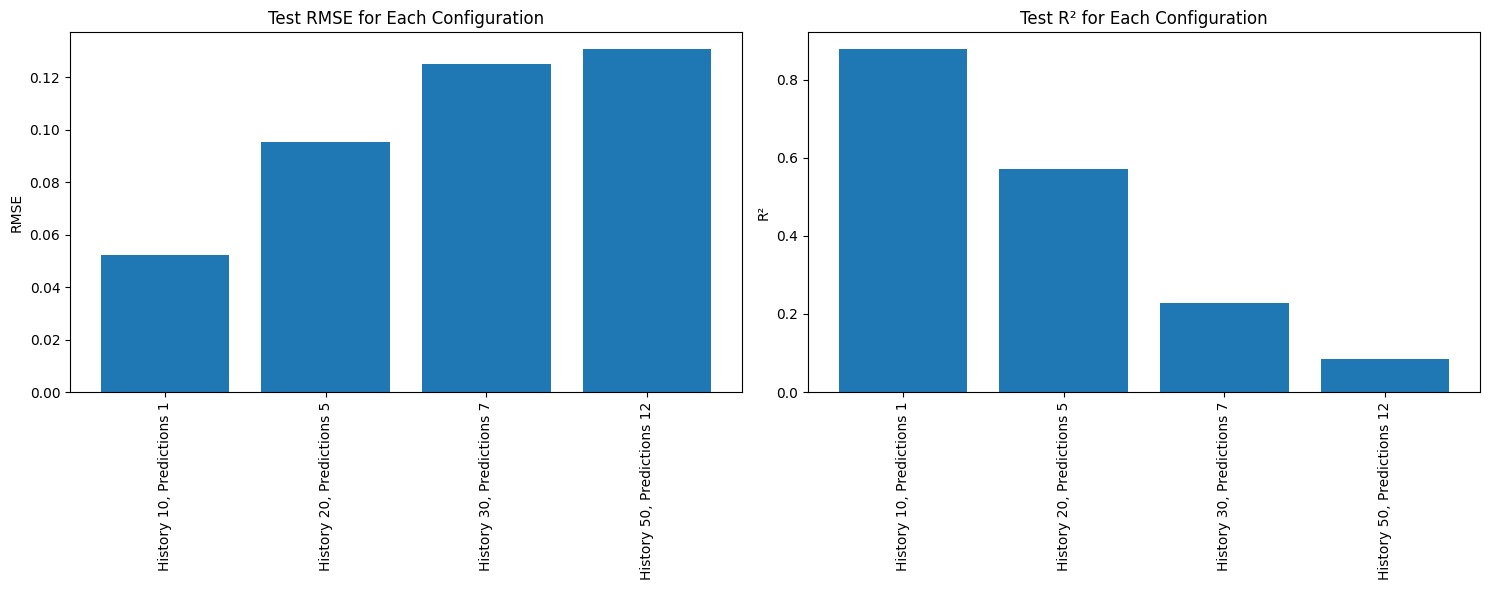

In [25]:
# Plot RMSE and R² for different configurations
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].bar(test_rmse.keys(), test_rmse.values())
ax[0].set_title("Test RMSE for Each Configuration")
ax[0].set_ylabel("RMSE")
ax[0].tick_params(axis='x', rotation=90, labelsize=10)

ax[1].bar(test_r2.keys(), test_r2.values())
ax[1].set_title("Test R² for Each Configuration")
ax[1].set_ylabel("R²")
ax[1].tick_params(axis='x', rotation=90, labelsize=10)

plt.tight_layout()
plt.show()